# 📊 Commax 데이터 분석 - 최종 EDA (Exploratory Data Analysis)

## 🎯 분석 목표
이 노트북은 Commax의 출하 데이터를 종합적으로 분석하여 다음과 같은 인사이트를 도출합니다:
- **데이터 구조 및 품질 확인**
- **타겟 변수(value) 분포 및 특성 분석**
- **품목별/분류별 출하 패턴 분석**
- **시계열 트렌드 및 계절성 분석**
- **외부 경제지표와의 연관성 분석**

## 📋 분석 흐름
1. **데이터 로딩 및 환경 설정** - 한글 폰트 설정, 라이브러리 임포트
2. **데이터 구조 분석** - 컬럼 분류, 기본 통계 확인
3. **타겟 변수 분석** - value 컬럼의 분포 및 특성
4. **품목별 분석** - 품목별 판매 패턴 및 통계
5. **시계열 분석** - 월별/연도별 출하량 추이
6. **외부 경제지표 분석** - 경제 변수들의 결측값 및 분포
7. **종합 분석** - 시계열 분해, 분기별 추이 등

---


## 1️⃣ 데이터 로딩 및 환경 설정

### 📌 주요 작업 내용
- **한글 폰트 설정**: macOS 환경에서 한글 시각화를 위한 폰트 설정
- **필요 라이브러리 임포트**: pandas, numpy, matplotlib, seaborn 등
- **데이터 로딩**: Final_KR_modeling_long_with_external_data.csv 파일 로드
- **컬럼 분류**: 기본 컬럼, 외부 경제지표, KOSIS 데이터, EPU 데이터로 분류
- **데이터 전처리**: 외부 변수의 0값을 NaN으로 변환 (결측값 처리)

### 🔍 확인할 사항
- 데이터 크기: 20,096행 × 240컬럼
- 외부 변수 수: 85개
- 0값을 NaN으로 변환한 변수 수: 67개


In [16]:
# 1. 데이터 로딩 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_korean_font():
    """가상환경에서 한글 폰트 설정"""
    system = platform.system()
    
    if system == 'Darwin':  # macOS
        korean_fonts = ['AppleGothic', 'Apple SD Gothic Neo', 'NanumGothic', 'Malgun Gothic']
        font_list = [f.name for f in fm.fontManager.ttflist]
        available_fonts = [font for font in korean_fonts if font in font_list]
        
        if available_fonts:
            selected_font = available_fonts[0]
            plt.rcParams['font.family'] = selected_font
            rc('font', family=selected_font)
            print(f"한글 폰트 설정: {selected_font}")
            return True
        else:
            print("한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
            plt.rcParams['font.family'] = 'DejaVu Sans'
            rc('font', family='DejaVu Sans')
            return False
    
    elif system == 'Windows':  # Windows
        korean_fonts = ['Malgun Gothic', 'NanumGothic', 'Gulim', 'Dotum']
        font_list = [f.name for f in fm.fontManager.ttflist]
        available_fonts = [font for font in korean_fonts if font in font_list]
        
        if available_fonts:
            selected_font = available_fonts[0]
            plt.rcParams['font.family'] = selected_font
            rc('font', family=selected_font)
            print(f"한글 폰트 설정: {selected_font}")
            return True
        else:
            plt.rcParams['font.family'] = 'DejaVu Sans'
            rc('font', family='DejaVu Sans')
            return False
    
    else:  # Linux
        plt.rcParams['font.family'] = 'DejaVu Sans'
        rc('font', family='DejaVu Sans')
        return False

# 한글 폰트 설정 시도
korean_font_available = setup_korean_font()

# 기본 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

# Seaborn 스타일 설정
sns.set_style("whitegrid")
sns.set_palette("husl")

# 데이터 로딩
print("데이터 로딩 중...")
df = pd.read_csv('../../data/raw/Final_KR_modeling_long_with_external_data.csv')

print(f"데이터 크기: {df.shape}")
print(f"컬럼 수: {len(df.columns)}")

# 컬럼 카테고리 분류
basic_cols = ['품목코드', '품목명', '품목그룹', '품목그룹명', '칼라코드', '모듈코드', 
              '분류1', '분류2', '분류3', '분류4', '분류5', '모델', '국가', 'Pattern',
              'total_months', 'nonzero_months', 'zero_months', 'start_date', 'end_date', 'period', 'value']

external_cols = [col for col in df.columns if col.startswith(('EX_', 'Idx_', 'Bonds_', 'Com_'))]
kosis_cols = [col for col in df.columns if col.startswith('_ext_KOSIS')]
epu_cols = [col for col in df.columns if 'EPU' in col]

# 외부 변수에서 0값을 NaN으로 변환
print(f"\n외부 변수에서 0값을 NaN으로 변환 중...")
print(f"외부 변수 수: {len(external_cols)}")

# 변환 전 0값 개수 확인
zero_counts_before = {}
for col in external_cols:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        zero_counts_before[col] = zero_count

print(f"변환 전 0값이 있는 변수 수: {len(zero_counts_before)}")

# 0값을 NaN으로 변환
for col in external_cols:
    df[col] = df[col].replace(0, np.nan)

# 변환 후 NaN 개수 확인
nan_counts_after = {}
for col in external_cols:
    nan_count = df[col].isnull().sum()
    if nan_count > 0:
        nan_counts_after[col] = nan_count

print(f"변환 후 NaN이 있는 변수 수: {len(nan_counts_after)}")

# 변환 요약
print(f"\n변환 요약:")
print(f"총 외부 변수 수: {len(external_cols)}")
print(f"0값이 변환된 변수 수: {len(zero_counts_before)}")
print(f"변환 후 NaN이 있는 변수 수: {len(nan_counts_after)}")

print("\n데이터 기본 정보:")
print(df.info())


한글 폰트 설정: AppleGothic
데이터 로딩 중...
데이터 크기: (20096, 240)
컬럼 수: 240

외부 변수에서 0값을 NaN으로 변환 중...
외부 변수 수: 85
변환 전 0값이 있는 변수 수: 67
변환 후 NaN이 있는 변수 수: 67

변환 요약:
총 외부 변수 수: 85
0값이 변환된 변수 수: 67
변환 후 NaN이 있는 변수 수: 67

데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096 entries, 0 to 20095
Columns: 240 entries, 품목코드 to _ext_KOSIS163
dtypes: float64(222), int64(4), object(14)
memory usage: 36.8+ MB
None


## 2️⃣ 데이터 구조 분석

### 📌 주요 작업 내용
- **데이터 크기 확인**: 총 20,096행, 240컬럼
- **컬럼 분류 확인**: 기본 컬럼(21개), 외부 경제지표(85개), KOSIS(134개), EPU(18개)
- **데이터 샘플 확인**: 첫 5행 데이터 미리보기

### 🔍 확인할 사항
- 모든 컬럼이 적절히 분류되었는지 확인
- 데이터 타입과 기본 구조 파악


In [17]:
# 2. 데이터 구조 분석
print("=== 데이터 구조 분석 ===")
print(f"총 행 수: {len(df):,}")
print(f"총 컬럼 수: {len(df.columns)}")

# 기타 컬럼들 찾기
all_categorized = set(basic_cols + external_cols + kosis_cols + epu_cols)
other_cols = [col for col in df.columns if col not in all_categorized]

print(f"\n기본 컬럼 수: {len(basic_cols)}")
print(f"외부 경제지표 컬럼 수: {len(external_cols)}")
print(f"KOSIS 컬럼 수: {len(kosis_cols)}")
print(f"EPU 컬럼 수: {len(epu_cols)}")
print(f"기타 컬럼 수: {len(other_cols)}")

print(f"\n합계: {len(basic_cols) + len(external_cols) + len(kosis_cols) + len(epu_cols) + len(other_cols)}")

if other_cols:
    print(f"\n기타 컬럼들: {other_cols}")

# 첫 5행 확인
print("\n=== 데이터 샘플 ===")
print(df.head())


=== 데이터 구조 분석 ===
총 행 수: 20,096
총 컬럼 수: 240

기본 컬럼 수: 21
외부 경제지표 컬럼 수: 85
KOSIS 컬럼 수: 134
EPU 컬럼 수: 18
기타 컬럼 수: 0

합계: 258

=== 데이터 샘플 ===
       품목코드                   품목명  품목그룹 품목그룹명  칼라코드  모듈코드         분류1 분류2 분류3  \
0  AME00073  MULTI 4PORT 4PCI-232   104    상품   NaN   NaN  Door Entry  기타  기타   
1  AME00073  MULTI 4PORT 4PCI-232   104    상품   NaN   NaN  Door Entry  기타  기타   
2  AME00073  MULTI 4PORT 4PCI-232   104    상품   NaN   NaN  Door Entry  기타  기타   
3  AME00073  MULTI 4PORT 4PCI-232   104    상품   NaN   NaN  Door Entry  기타  기타   
4  AME00073  MULTI 4PORT 4PCI-232   104    상품   NaN   NaN  Door Entry  기타  기타   

   분류4  ... _ext_KOSIS149 _ext_KOSIS150 _ext_KOSIS151 _ext_KOSIS152  \
0  NaN  ...          74.0          95.0         106.0          95.0   
1  NaN  ...          75.0          94.0         104.0          98.0   
2  NaN  ...          78.0          95.0         103.0          97.0   
3  NaN  ...          82.0          97.0         104.0          94.0   
4  NaN  ...        

## 3️⃣ 타겟 변수(value) 분석

### 📌 주요 작업 내용
- **기본 통계 확인**: 평균, 중간값, 표준편차, 최대/최소값
- **0값 분석**: 전체 데이터 중 0값의 비율 확인 (31.06%)
- **양수값 분석**: 실제 판매가 발생한 데이터만 필터링하여 분석
- **분포 시각화**: 히스토그램으로 전체값, 양수값, 로그변환 분포 확인

### 🔍 주요 발견사항
- **0값 비율**: 31.06% (6,242개)
- **양수값 비율**: 68.94% (13,854개)
- **평균 판매량**: 283.69 (전체), 411.52 (양수값만)
- **최대 판매량**: 23,983 단위


=== 타겟 변수(value) 분석 ===
Value 컬럼 통계:
count    20096.000000
mean       283.694865
std        761.329849
min          0.000000
25%          0.000000
50%         22.000000
75%        226.000000
max      23983.000000
Name: value, dtype: float64

0값 개수: 6,242 (31.06%)

양수값 개수: 13,854
양수값 통계:
count    13854.000000
mean       411.515230
std        887.801065
min          1.000000
25%         19.000000
50%         98.000000
75%        440.000000
max      23983.000000
Name: value, dtype: float64


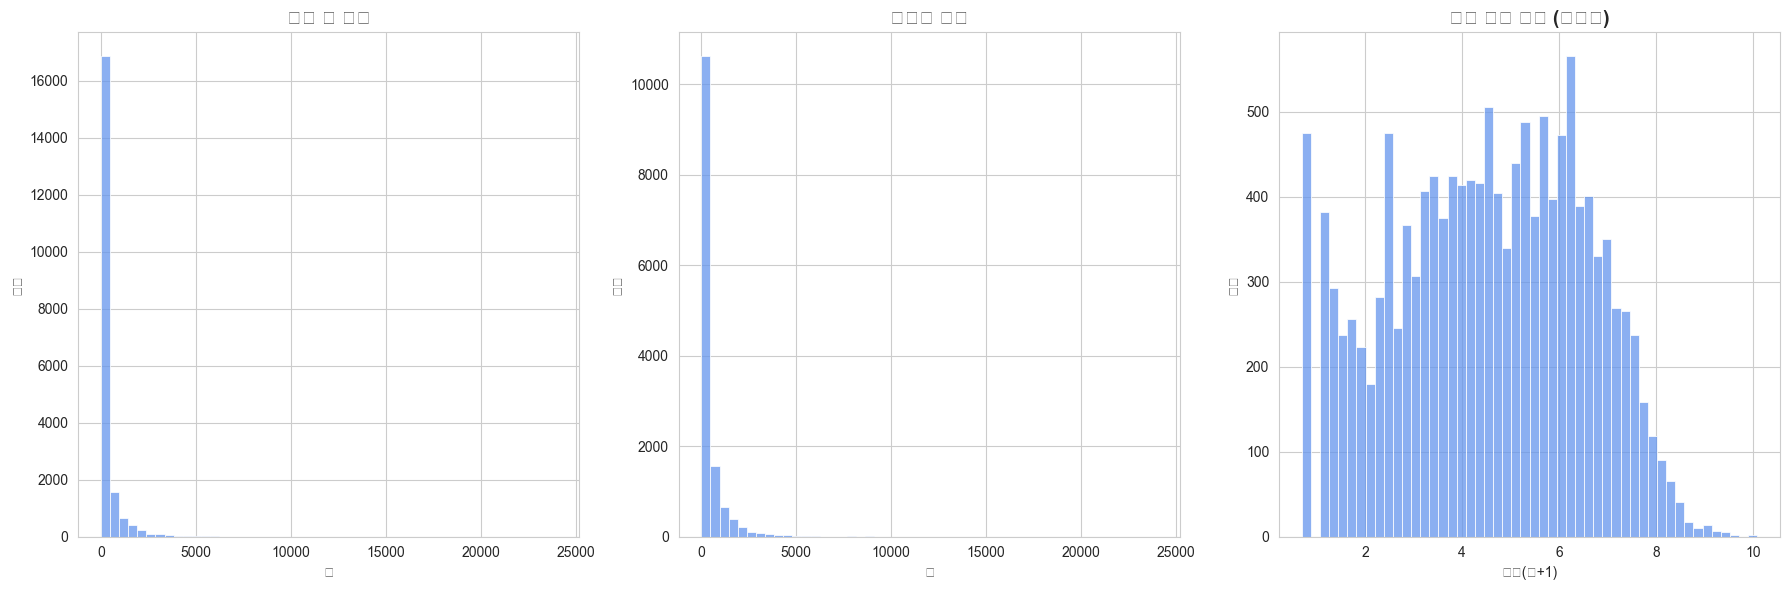

In [19]:
# 3. 타겟 변수(value) 분석
print("=== 타겟 변수(value) 분석 ===")
print(f"Value 컬럼 통계:")
print(df['value'].describe())

# 0값 비율 확인
zero_count = (df['value'] == 0).sum()
zero_ratio = zero_count / len(df) * 100
print(f"\n0값 개수: {zero_count:,} ({zero_ratio:.2f}%)")

# 양수값만 필터링
positive_df = df[df['value'] > 0]
print(f"\n양수값 개수: {len(positive_df):,}")
print("양수값 통계:")
print(positive_df['value'].describe())

# Seaborn 히스토그램
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 사용할 색상 지정 (원하는 색상 코드로 변경 가능합니다)
# 예: 'cornflowerblue', 'skyblue', 'dodgerblue', '#4a90e2' (Hex 코드)
target_color = 'cornflowerblue'

# 1. 모든 값 분포
sns.histplot(data=df, x='value', bins=50, ax=axes[0], color=target_color, edgecolor='white')
axes[0].set_title('전체 값 분포', fontsize=14, fontweight='bold')
axes[0].set_xlabel('값')
axes[0].set_ylabel('빈도')

# 2. 양수값만 분포
sns.histplot(data=positive_df, x='value', bins=50, ax=axes[1], color=target_color, edgecolor='white')
axes[1].set_title('양수값 분포', fontsize=14, fontweight='bold')
axes[1].set_xlabel('값')
axes[1].set_ylabel('빈도')

# 3. 로그 변환 분포
sns.histplot(data=positive_df, x=np.log1p(positive_df['value']), bins=50, ax=axes[2], color=target_color, edgecolor='white')
axes[2].set_title('로그 변환 분포 (양수값)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('로그(값+1)')
axes[2].set_ylabel('빈도')

plt.tight_layout()
plt.show()

## 4️⃣ 품목별 분석

### 📌 주요 작업 내용
- **품목 현황**: 고유 품목 수 확인 (157개)
- **판매량 상위 품목**: 총 판매량 기준 상위 10개 품목 분석
- **Pattern 분석**: Erratic, Intermittent, Smooth 패턴별 분포 및 통계
- **시각화**: 패턴별 데이터 수, 총 판매량, 평균 판매량, 값 분포 확인

### 🔍 주요 발견사항
- **고유 품목 수**: 157개
- **최고 판매 품목**: SDC000036AXX (총 538,250 단위)


=== 품목별 분석 ===
고유 품목 수: 157
고유 품목명 수: 157

판매량 상위 10개 품목:
              판매횟수      총판매량    평균판매량  판매량표준편차
품목코드                                          
SDC000036AXX   128  538250.0  4205.08  4741.32
EM4605230AXX   128  262663.0  2052.05  1016.87
ETZ000024CXX   128  228929.0  1788.51  2009.91
UV9000731A     128  219682.0  1716.27   886.76
DCC000156AXX   128  205957.0  1609.04  1694.94
DCC000136AXX   128  179692.0  1403.84  1419.18
PAS000040AXX   128  167165.0  1305.98   997.86
PAS000019AXX   128  163373.0  1276.35   701.58
HAD000026AXC   128  155981.0  1218.60  1140.97
DLX000006FXX   128  153867.0  1202.09  1510.06

품목별 Pattern 분포:
Pattern       Erratic  Intermittent  Smooth
품목코드                                       
AME00073            0             0     128
CTB000013AXX      128             0       0
CTC000175AXX      128             0       0
CTC000191AXX        0             0     128
CTC000193AXX        0             0     128
CTD000239BXX        0           128       0
CTD000240

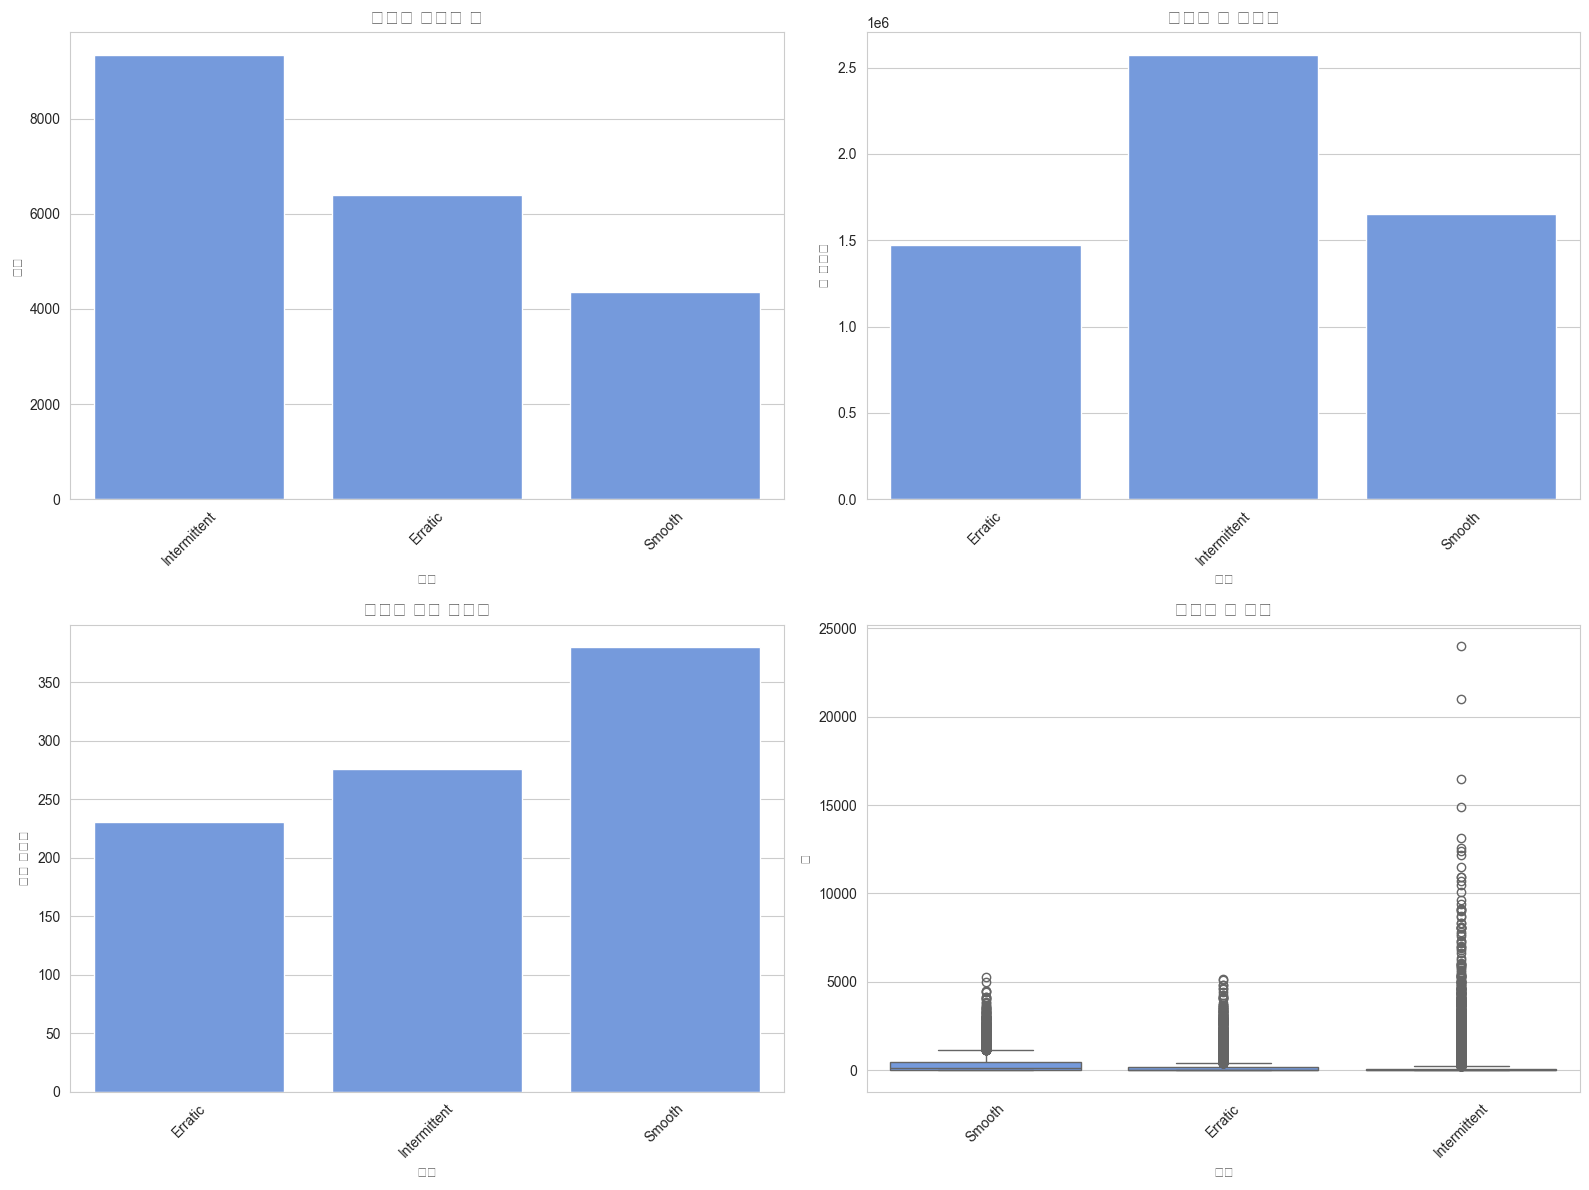

In [21]:
# 4. 품목별 분석
print("=== 품목별 분석 ===")
print(f"고유 품목 수: {df['품목코드'].nunique()}")
print(f"고유 품목명 수: {df['품목명'].nunique()}")

# 품목별 판매량 통계
item_stats = df.groupby('품목코드')['value'].agg(['count', 'sum', 'mean', 'std']).round(2)
item_stats.columns = ['판매횟수', '총판매량', '평균판매량', '판매량표준편차']

# 판매량 상위 10개 품목
top_items = item_stats.sort_values('총판매량', ascending=False).head(10)
print("\n판매량 상위 10개 품목:")
print(top_items)

# 품목별 판매 패턴 분석
item_patterns = df.groupby(['품목코드', 'Pattern']).size().unstack(fill_value=0)
print(f"\n품목별 Pattern 분포:")
print(item_patterns.head(10))

# Pattern별 통계
pattern_stats = df.groupby('Pattern')['value'].agg(['count', 'sum', 'mean']).round(2)
pattern_stats.columns = ['데이터수', '총판매량', '평균판매량']
print(f"\nPattern별 판매 통계:")
print(pattern_stats)

# (이전 데이터 전처리 코드는 그대로 유지한다고 가정합니다)

# Seaborn 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 사용할 색상 지정
target_color = 'cornflowerblue'

# 1. Pattern별 데이터 수
# color로 색상을 지정하고, edgecolor로 테두리를 하얗게 처리하여 깔끔하게 만듭니다.
pattern_counts = df['Pattern'].value_counts()
sns.barplot(x=pattern_counts.index, y=pattern_counts.values, ax=axes[0,0], color=target_color, edgecolor='white')
axes[0,0].set_title('패턴별 데이터 수', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('패턴')
axes[0,0].set_ylabel('개수')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Pattern별 총 판매량
sns.barplot(data=pattern_stats.reset_index(), x='Pattern', y='총판매량', ax=axes[0,1], color=target_color, edgecolor='white')
axes[0,1].set_title('패턴별 총 판매량', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('패턴')
axes[0,1].set_ylabel('총 판매량')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Pattern별 평균 판매량
sns.barplot(data=pattern_stats.reset_index(), x='Pattern', y='평균판매량', ax=axes[1,0], color=target_color, edgecolor='white')
axes[1,0].set_title('패턴별 평균 판매량', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('패턴')
axes[1,0].set_ylabel('평균 판매량')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Pattern별 값 분포 (박스플롯)
# 박스플롯에도 color를 적용하면 내부가 해당 색으로 칠해집니다.
sns.boxplot(data=df, x='Pattern', y='value', ax=axes[1,1], color=target_color)
axes[1,1].set_title('패턴별 값 분포', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('패턴')
axes[1,1].set_ylabel('값')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 5️⃣ 시계열 분석

### 📌 주요 작업 내용
- **데이터 기간 확인**: 2015-01-01 ~ 2025-08-01 (총 3,865일)
- **월별 판매량 추이**: 월별 총 판매량 계산 및 상위 10개월 확인
- **연도별/월별 분석**: 연도별 총 판매량, 월별 평균 판매량 분석
- **시계열 시각화**: 월별 추이 선그래프, 막대그래프, 연도별 비교

### 🔍 주요 발견사항
- **최고 판매 월**: 2020년 12월 (88,011 단위)
- **계절성 패턴**: 12월에 판매량이 높은 경향
- **전체 기간**: 약 10년 7개월의 데이터


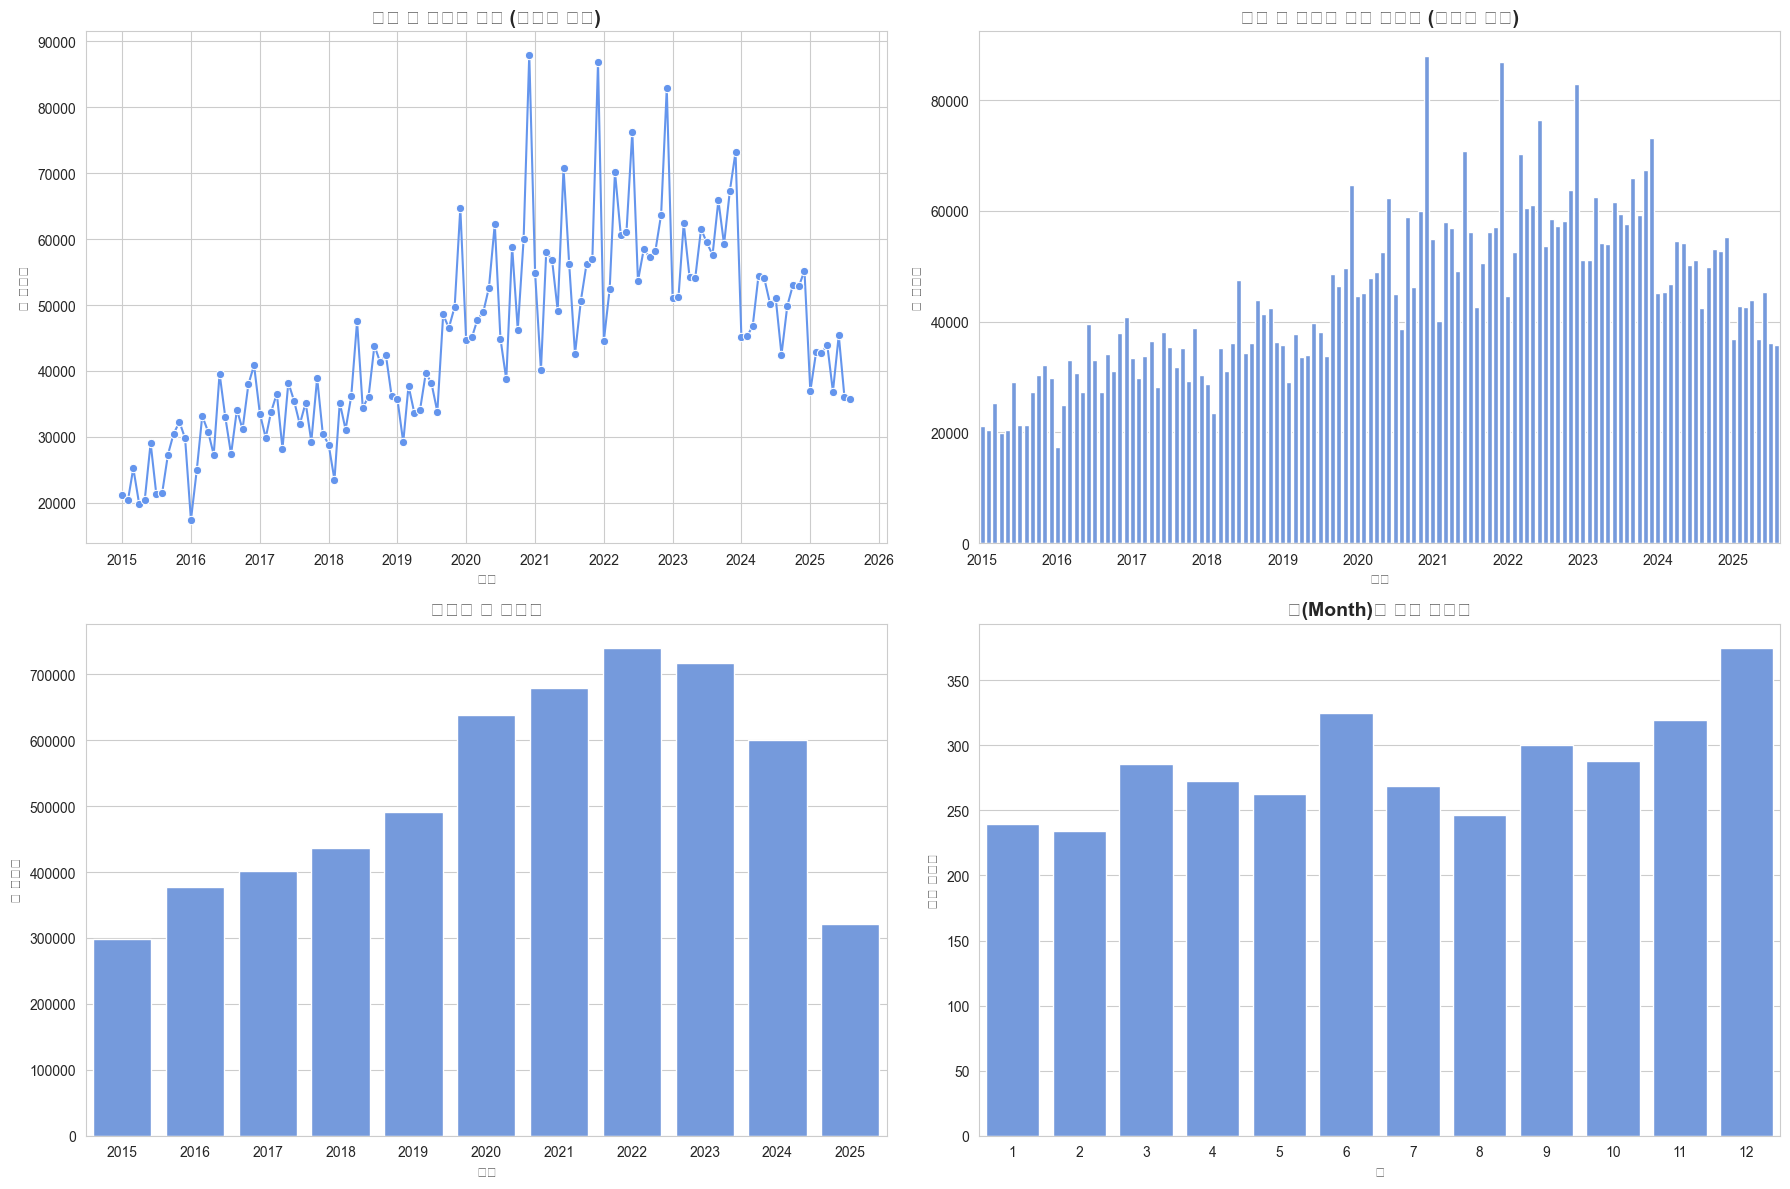

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# === 데이터 전처리 (기존 로직 유지 및 시각화용 변환) ===
# 날짜 컬럼 변환
df['period'] = pd.to_datetime(df['period'])

# 월별 판매량 집계 (PeriodIndex 사용)
monthly_sales = df.groupby(df['period'].dt.to_period('M'))['value'].sum()
monthly_df = monthly_sales.reset_index()

# *** 중요: 시각화를 위해 Period 타입을 Timestamp(날짜)와 문자열로 변환 ***
# 선 그래프용 (날짜 인식)
monthly_df['period_dt'] = monthly_df['period'].dt.to_timestamp()
# 막대 그래프용 (문자열 인식)
monthly_df['period_str'] = monthly_df['period'].astype(str)

# 연도별 판매량
yearly_sales = df.groupby(df['period'].dt.year)['value'].sum()
yearly_df = yearly_sales.reset_index()

# 월별 평균 판매량
monthly_avg = df.groupby(df['period'].dt.month)['value'].mean()
monthly_avg_df = monthly_avg.reset_index()

# === 시각화 ===
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 사용할 색상
target_color = 'cornflowerblue'

# 1. 월별 총 판매량 추이 (선 그래프) -> X축 날짜 포맷팅 적용
sns.lineplot(data=monthly_df, x='period_dt', y='value', ax=axes[0,0], marker='o', color=target_color)
axes[0,0].set_title('월별 총 판매량 추이 (연도별 표시)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('연도')
axes[0,0].set_ylabel('총 판매량')

# X축 포맷팅: 주요 눈금을 '연도(Year)' 단위로 설정
axes[0,0].xaxis.set_major_locator(mdates.YearLocator())     # 1년 단위로 눈금 표시
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # 'YYYY' 형태로 표시


# 2. 월별 총 판매량 (막대 그래프) -> 1월 위치만 찾아서 연도 표시
sns.barplot(data=monthly_df, x='period_str', y='value', ax=axes[0,1], color=target_color, edgecolor='white')
axes[0,1].set_title('월별 총 판매량 막대 그래프 (연도별 표시)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('연도')
axes[0,1].set_ylabel('총 판매량')

# 막대 그래프 X축 커스텀: 'YYYY-01'로 끝나는 데이터의 인덱스와 연도만 추출
ticks = []
labels = []
for i, date_str in enumerate(monthly_df['period_str']):
    if date_str.endswith('-01'):  # 1월인 경우에만
        ticks.append(i)           # 해당 막대의 인덱스 저장
        labels.append(date_str[:4]) # '2023-01' -> '2023'만 추출

axes[0,1].set_xticks(ticks)       # 1월 위치에만 눈금 설정
axes[0,1].set_xticklabels(labels) # 연도 라벨 설정


# 3. 연도별 판매량
sns.barplot(data=yearly_df, x='period', y='value', ax=axes[1,0], color=target_color, edgecolor='white')
axes[1,0].set_title('연도별 총 판매량', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('연도')
axes[1,0].set_ylabel('총 판매량')


# 4. 월별 평균 판매량 (1~12월)
sns.barplot(data=monthly_avg_df, x='period', y='value', ax=axes[1,1], color=target_color, edgecolor='white')
axes[1,1].set_title('월(Month)별 평균 판매량', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('월')
axes[1,1].set_ylabel('평균 판매량')

plt.tight_layout()
plt.show()

## 6️⃣ 외부 경제지표 분석

### 📌 주요 작업 내용
- **외부 지표 분류**: EX, Idx, Bonds, Com 카테고리별 분석
- **결측값 분석**: 각 외부 지표의 결측값 비율 확인
- **데이터 품질 평가**: 결측값이 적은 상위 10개 외부 지표 식별
- **분포 시각화**: 결측값이 적은 외부 지표들의 분포 히스토그램

### 🔍 주요 발견사항
- **외부 지표 총 수**: 85개
- **카테고리별 분포**: EX(6개), Idx(27개), Bonds(18개), Com(34개)
- **결측값이 있는 컬럼**: 67개
- **결측값이 10% 미만인 지표**: 10개 (모두 EPU 관련 지표)


=== 외부 경제지표 분석 ===
외부 경제지표 컬럼 수: 85
외부 경제지표 카테고리:
  EX: 6개 컬럼
  Idx: 27개 컬럼
  Bonds: 18개 컬럼
  Com: 34개 컬럼

외부 지표 결측값 분석:
결측값이 있는 컬럼 수: 67
50% 이상 결측값이 있는 컬럼 수: 0

결측값이 10% 미만인 외부 지표 (상위 10개):
  Bonds_AUS_10Y.close: 9.38%
  Bonds_KOR_10Y.close: 9.38%
  Idx_GEPU_current: 0.0%
  Idx_GEPU_ppp: 0.0%
  Idx_EPU_Brazil: 0.0%
  Idx_EPU_Canada: 0.0%
  Idx_EPU_Chile: 0.0%
  Idx_EPU_Germany: 0.0%
  Idx_EPU_Greece: 0.0%
  Idx_EPU_India: 0.0%


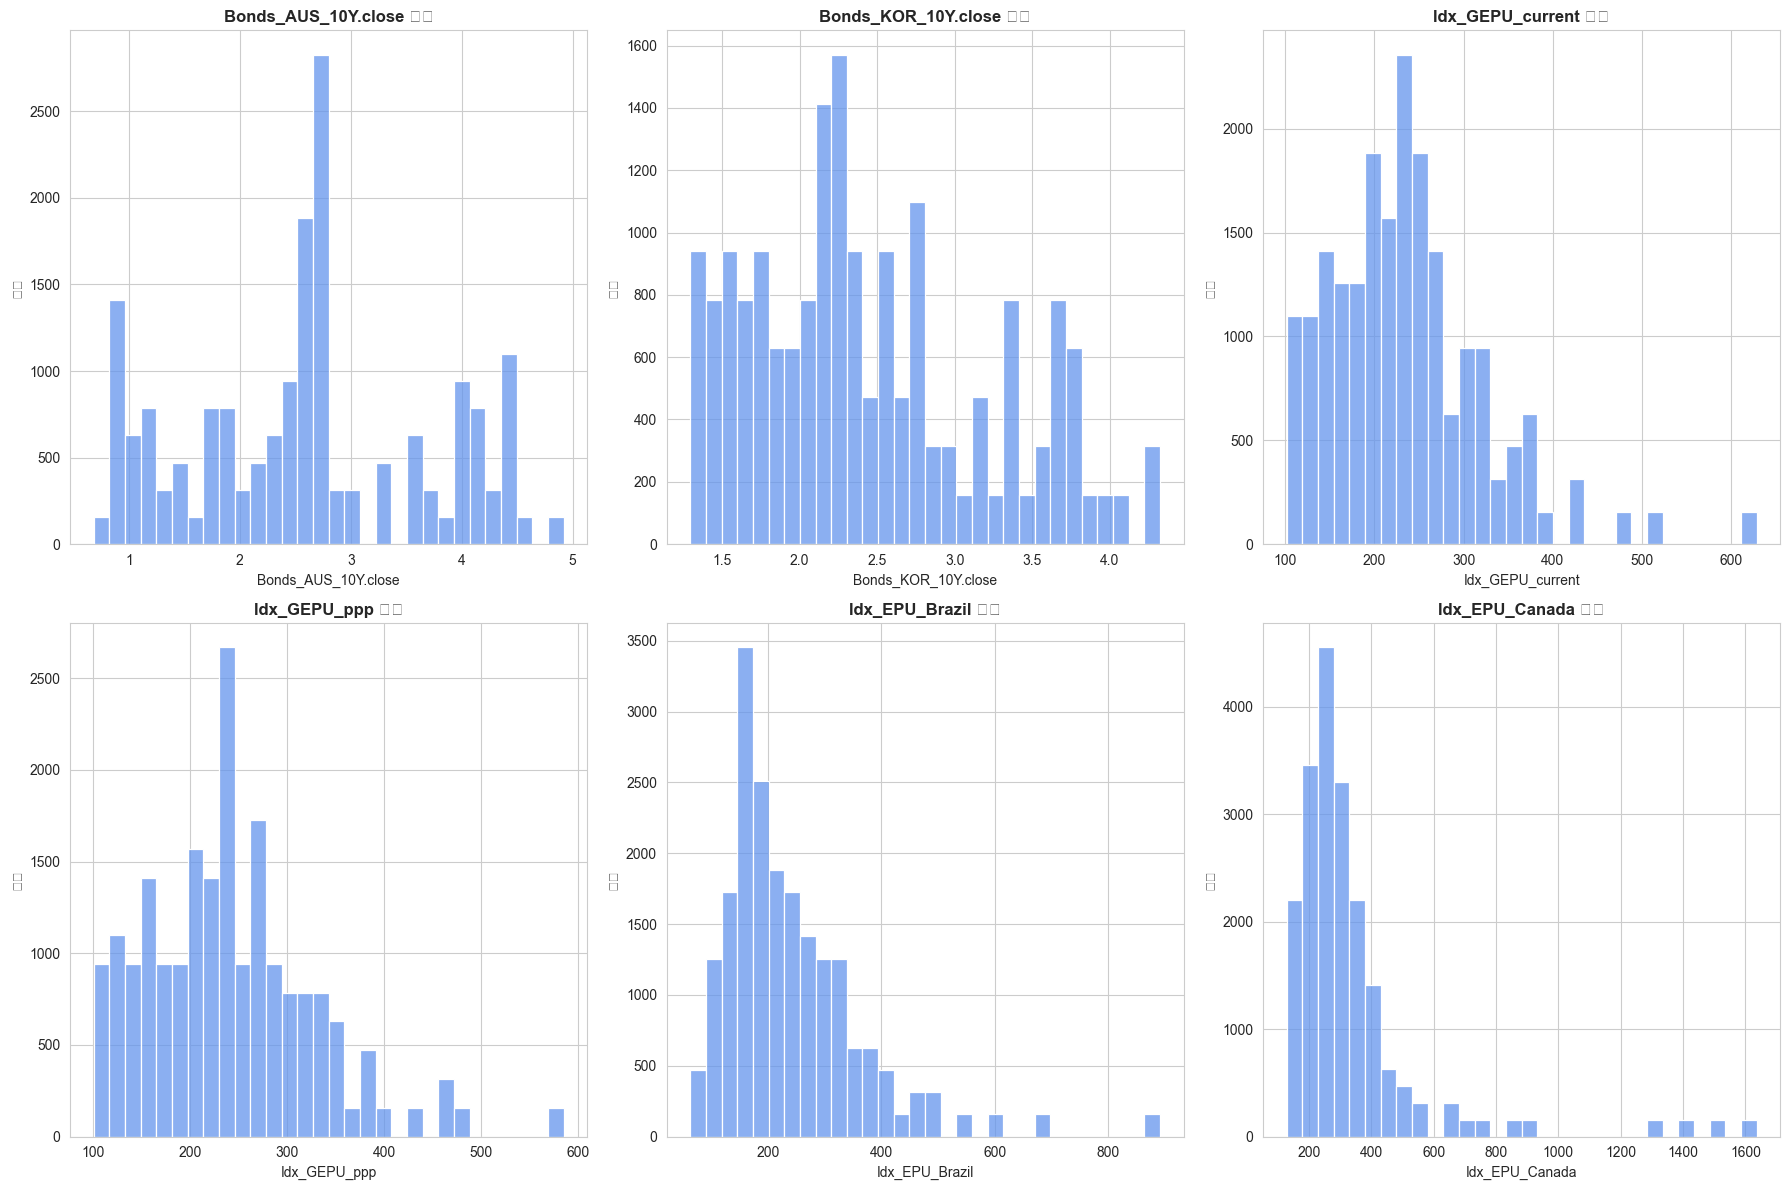

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# (이전 데이터 분석 로직은 그대로 유지합니다)
print("=== 외부 경제지표 분석 ===")

# 외부 경제지표 컬럼 분석
print(f"외부 경제지표 컬럼 수: {len(external_cols)}")
print("외부 경제지표 카테고리:")
ex_categories = {}
for col in external_cols:
    category = col.split('_')[0]
    if category not in ex_categories:
        ex_categories[category] = []
    ex_categories[category].append(col)

for category, cols in ex_categories.items():
    print(f"  {category}: {len(cols)}개 컬럼")

# 외부 지표에서 결측값 분석
external_data = df[external_cols]
missing_stats = external_data.isnull().sum()
missing_ratio = (missing_stats / len(df) * 100).round(2)

print(f"\n외부 지표 결측값 분석:")
print(f"결측값이 있는 컬럼 수: {(missing_stats > 0).sum()}")
print(f"50% 이상 결측값이 있는 컬럼 수: {(missing_ratio > 50).sum()}")

# 결측값이 적은 상위 10개 외부 지표
low_missing_cols = missing_ratio[missing_ratio < 10].head(10)
print(f"\n결측값이 10% 미만인 외부 지표 (상위 10개):")
for col, ratio in low_missing_cols.items():
    print(f"  {col}: {ratio}%")

# === Seaborn 시각화 (색상 변경 적용) ===
if len(low_missing_cols) > 0:
    # 결측값이 적은 외부 지표들의 분포
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 사용할 색상
    target_color = 'cornflowerblue'

    # 상위 6개 지표만 시각화
    for i, col in enumerate(low_missing_cols.index[:6]):
        if i < len(axes):
            # color와 edgecolor 적용
            sns.histplot(data=df, x=col, bins=30, ax=axes[i], color=target_color, edgecolor='white')
            axes[i].set_title(f'{col} 분포', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('빈도')
    
    # 데이터보다 서브플롯 칸이 많을 경우 빈 칸 숨기기
    # (low_missing_cols가 6개 미만일 경우 에러 방지 로직 수정 포함)
    plot_count = min(len(low_missing_cols), 6)
    for i in range(plot_count, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 7️⃣ 타겟 변수(value) 종합 분석

### 📌 주요 작업 내용
- **상세 통계**: 최대/최소값, 평균/중간값, 표준편차, 분산 계산
- **결측값/0값/음수값 분석**: 각 유형별 개수와 비율 확인
- **이상값 분석**: IQR 방법을 사용한 이상값 탐지
- **분포 특성**: 왜도, 첨도 계산으로 분포 형태 파악
- **박스플롯 시각화**: 값의 분포와 이상값 시각적 확인

### 🔍 주요 발견사항
- **결측값**: 0개 (0.00%)
- **0값**: 6,242개 (31.06%)
- **양수값**: 13,854개 (68.94%)
- **이상값**: 2,750개 (13.68%)
- **분포 특성**: 높은 왜도(8.38)와 첨도(136.99) - 오른쪽 꼬리가 긴 분포


=== 타겟 변수(value) 종합 분석 ===
기본 통계:
count    20096.000000
mean       283.694865
std        761.329849
min          0.000000
25%          0.000000
50%         22.000000
75%        226.000000
max      23983.000000
Name: value, dtype: float64

상세 통계:
최대값: 23,983.00
최소값: 0.00
평균값: 283.69
중간값: 22.00
표준편차: 761.33
분산: 579,623.14

결측값 분석:
결측값 개수: 0
결측값 비율: 0.00%
비결측값 개수: 20,096

0값 분석:
0값 개수: 6,242
0값 비율: 31.06%

음수값 분석:
음수값 개수: 0
음수값 비율: 0.00%

양수값 분석:
양수값 개수: 13,854
양수값 비율: 68.94%

이상값 분석 (IQR 방법):
Q1 (25퍼센타일): 0.00
Q3 (75퍼센타일): 226.00
IQR: 226.00
하한선: -339.00
상한선: 565.00
이상값 개수: 2,750
이상값 비율: 13.68%

분포 분석:
왜도: 8.3808
첨도: 136.9900


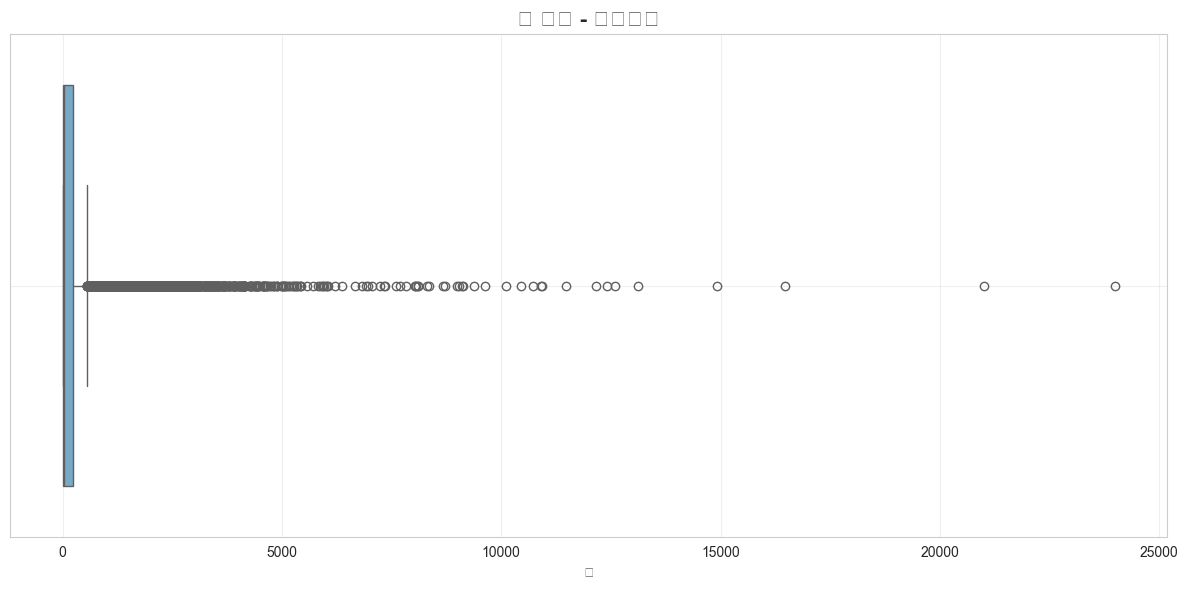


요약 테이블:
 지표    개수     비율 (%)
 개수 20096 100.000000
결측값     0   0.000000
 0값  6242  31.060908
음수값     0   0.000000
양수값 13854  68.939092
이상값  2750  13.684315


In [27]:
# 7. 타겟 변수(value) 종합 분석
print("=== 타겟 변수(value) 종합 분석 ===")

# 기본 통계
print("기본 통계:")
print(df['value'].describe())

# 추가 통계
print(f"\n상세 통계:")
print(f"최대값: {df['value'].max():,.2f}")
print(f"최소값: {df['value'].min():,.2f}")
print(f"평균값: {df['value'].mean():,.2f}")
print(f"중간값: {df['value'].median():,.2f}")
print(f"표준편차: {df['value'].std():,.2f}")
print(f"분산: {df['value'].var():,.2f}")

# 결측값 분석
missing_count = df['value'].isnull().sum()
missing_ratio = (missing_count / len(df)) * 100
print(f"\n결측값 분석:")
print(f"결측값 개수: {missing_count:,}")
print(f"결측값 비율: {missing_ratio:.2f}%")
print(f"비결측값 개수: {len(df) - missing_count:,}")

# 0값 분석
zero_count = (df['value'] == 0).sum()
zero_ratio = (zero_count / len(df)) * 100
print(f"\n0값 분석:")
print(f"0값 개수: {zero_count:,}")
print(f"0값 비율: {zero_ratio:.2f}%")

# 음수값 분석
negative_count = (df['value'] < 0).sum()
negative_ratio = (negative_count / len(df)) * 100
print(f"\n음수값 분석:")
print(f"음수값 개수: {negative_count:,}")
print(f"음수값 비율: {negative_ratio:.2f}%")

# 양수값 분석
positive_count = (df['value'] > 0).sum()
positive_ratio = (positive_count / len(df)) * 100
print(f"\n양수값 분석:")
print(f"양수값 개수: {positive_count:,}")
print(f"양수값 비율: {positive_ratio:.2f}%")

# 이상값 분석 (IQR 방법)
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_count = ((df['value'] < lower_bound) | (df['value'] > upper_bound)).sum()
outliers_ratio = (outliers_count / len(df)) * 100

print(f"\n이상값 분석 (IQR 방법):")
print(f"Q1 (25퍼센타일): {Q1:.2f}")
print(f"Q3 (75퍼센타일): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"하한선: {lower_bound:.2f}")
print(f"상한선: {upper_bound:.2f}")
print(f"이상값 개수: {outliers_count:,}")
print(f"이상값 비율: {outliers_ratio:.2f}%")

# 분포 분석
print(f"\n분포 분석:")
print(f"왜도: {df['value'].skew():.4f}")
print(f"첨도: {df['value'].kurtosis():.4f}")

# 가로 박스플롯 생성
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='value', color='steelblue', palette='Blues')
plt.title('값 분포 - 박스플롯', fontsize=16, fontweight='bold')
plt.xlabel('값')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 요약 테이블
summary_data = {
    '지표': ['개수', '결측값', '0값', '음수값', '양수값', '이상값'],
    '개수': [len(df), missing_count, zero_count, negative_count, positive_count, outliers_count],
    '비율 (%)': [100.0, missing_ratio, zero_ratio, negative_ratio, positive_ratio, outliers_ratio]
}

summary_df = pd.DataFrame(summary_data)
print(f"\n요약 테이블:")
print(summary_df.to_string(index=False))


## 8️⃣ 연도별 총 출하량 분석

### 📌 주요 작업 내용
- **연도별 집계**: 2015-2025년 연도별 총 출하량 계산
- **성장률 분석**: 전년 대비 성장률 계산 및 추이 분석
- **최고/최저 성과 연도**: 성과 기준 상위/하위 연도 식별
- **시각화**: 연도별 출하량 막대그래프 생성
- **추가 분석**: 상위 3개 연도, 성장 패턴 분석

### 🔍 주요 발견사항
- **최고 성과 연도**: 2022년 (739,465 단위)
- **최저 성과 연도**: 2015년 (298,671 단위)
- **평균 성장률**: 3.3%
- **양의 성장률 연도**: 7개, 음의 성장률 연도: 3개
- **전체 기간 총 출하량**: 5,701,132 단위


=== 연도별 총 출하량 분석 ===
연도별 총 출하량:
      연도      총출하량
0   2015  298671.0
1   2016  377614.0
2   2017  401249.0
3   2018  436620.0
4   2019  491448.0
5   2020  638151.0
6   2021  679284.0
7   2022  739465.0
8   2023  717324.0
9   2024  600674.0
10  2025  320632.0

요약 통계:
총 연도 수: 11
평균 연간 출하량: 518,285
중간값 연간 출하량: 491,448
최대 연간 출하량: 739,465
최소 연간 출하량: 298,671

최고 성과 연도: 2022.0년 (739,465 단위)
최저 성과 연도: 2015.0년 (298,671 단위)

전년 대비 성장률:
2015.0년: 298,671 단위 (기준년도)
2016.0년: 377,614 단위 (+26.4%)
2017.0년: 401,249 단위 (+6.3%)
2018.0년: 436,620 단위 (+8.8%)
2019.0년: 491,448 단위 (+12.6%)
2020.0년: 638,151 단위 (+29.9%)
2021.0년: 679,284 단위 (+6.5%)
2022.0년: 739,465 단위 (+8.9%)
2023.0년: 717,324 단위 (-3.0%)
2024.0년: 600,674 단위 (-16.3%)
2025.0년: 320,632 단위 (-46.6%)


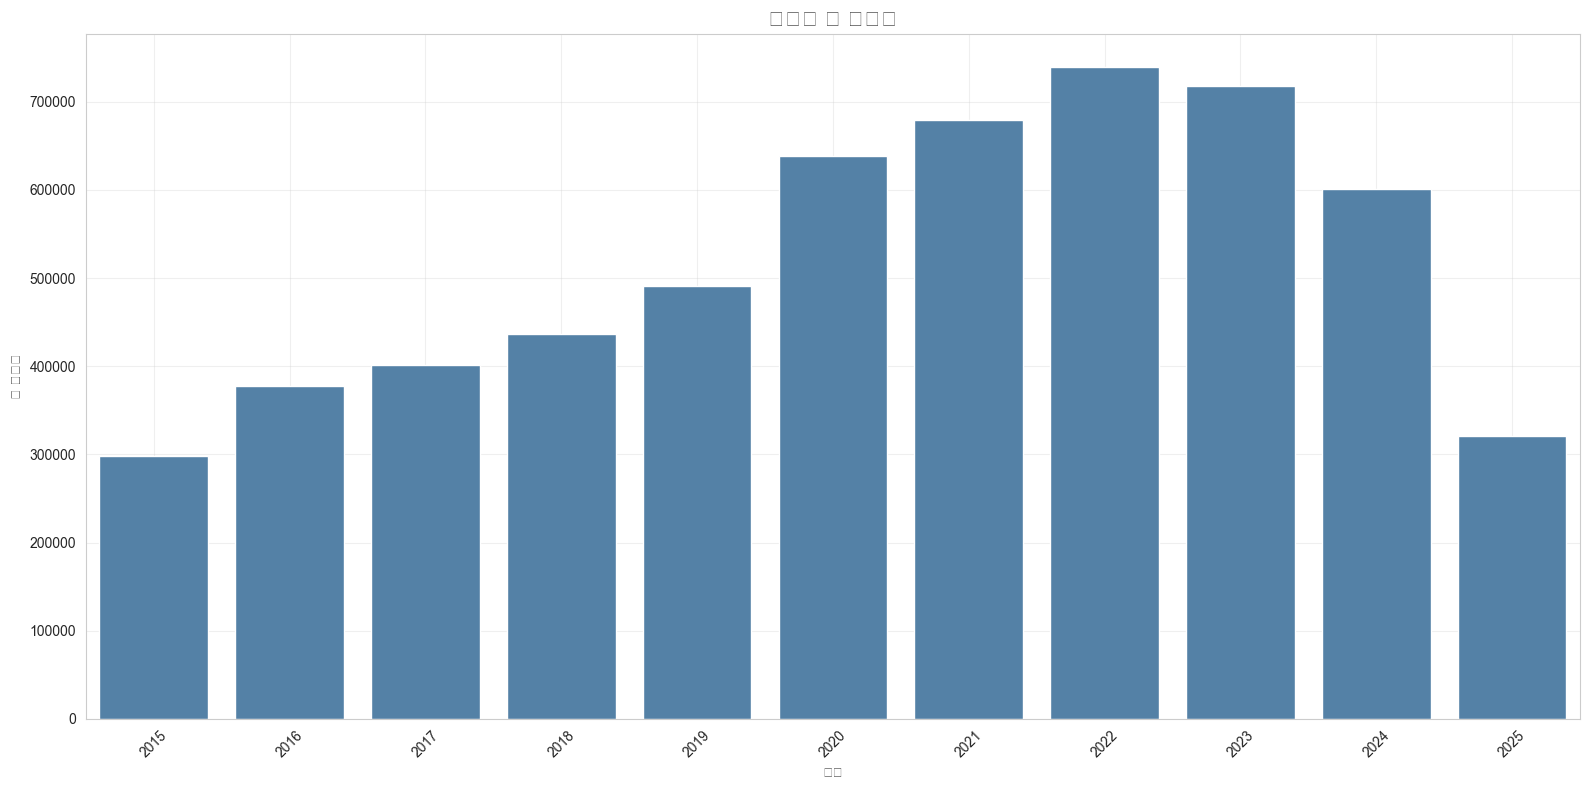


=== 추가 분석 ===
전체 기간 총 출하량: 5,701,132

출하량 기준 상위 3개 연도:
2022.0년: 739,465 단위 (13.0%)
2023.0년: 717,324 단위 (12.6%)
2021.0년: 679,284 단위 (11.9%)

성장 패턴:
양의 성장률 연도: 7개
음의 성장률 연도: 3개
평균 성장률: 3.3%


In [28]:
# 8. 연도별 총 출하량 분석
print("=== 연도별 총 출하량 분석 ===")

# period가 datetime인지 확인
df['period'] = pd.to_datetime(df['period'])

# 연도별 총 출하량 계산
yearly_shipments = df.groupby(df['period'].dt.year)['value'].sum().reset_index()
yearly_shipments.columns = ['연도', '총출하량']

print("연도별 총 출하량:")
print(yearly_shipments)

# 요약 통계 출력
print(f"\n요약 통계:")
print(f"총 연도 수: {len(yearly_shipments)}")
print(f"평균 연간 출하량: {yearly_shipments['총출하량'].mean():,.0f}")
print(f"중간값 연간 출하량: {yearly_shipments['총출하량'].median():,.0f}")
print(f"최대 연간 출하량: {yearly_shipments['총출하량'].max():,.0f}")
print(f"최소 연간 출하량: {yearly_shipments['총출하량'].min():,.0f}")

# 최고/최저 성과 연도 찾기
best_year = yearly_shipments.loc[yearly_shipments['총출하량'].idxmax()]
worst_year = yearly_shipments.loc[yearly_shipments['총출하량'].idxmin()]

print(f"\n최고 성과 연도: {best_year['연도']}년 ({best_year['총출하량']:,.0f} 단위)")
print(f"최저 성과 연도: {worst_year['연도']}년 ({worst_year['총출하량']:,.0f} 단위)")

# 전년 대비 성장률 계산
yearly_shipments['전년대비성장률'] = yearly_shipments['총출하량'].pct_change() * 100
yearly_shipments['전년대비성장률'] = yearly_shipments['전년대비성장률'].round(2)

print(f"\n전년 대비 성장률:")
for idx, row in yearly_shipments.iterrows():
    if pd.isna(row['전년대비성장률']):
        print(f"{row['연도']}년: {row['총출하량']:,.0f} 단위 (기준년도)")
    else:
        print(f"{row['연도']}년: {row['총출하량']:,.0f} 단위 ({row['전년대비성장률']:+.1f}%)")

# Seaborn 막대 그래프 생성
plt.figure(figsize=(16, 8))
sns.barplot(data=yearly_shipments, x='연도', y='총출하량', color='steelblue')
plt.title('연도별 총 출하량', fontsize=16, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('총 출하량')
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 추가 분석
print(f"\n=== 추가 분석 ===")
total_shipments = yearly_shipments['총출하량'].sum()
print(f"전체 기간 총 출하량: {total_shipments:,.0f}")

# 상위 3개 연도
top3_years = yearly_shipments.nlargest(3, '총출하량')
print(f"\n출하량 기준 상위 3개 연도:")
for idx, row in top3_years.iterrows():
    print(f"{row['연도']}년: {row['총출하량']:,.0f} 단위 ({row['총출하량']/total_shipments*100:.1f}%)")

# 성장률 분석
growth_data = yearly_shipments.dropna(subset=['전년대비성장률'])
positive_growth_years = len(growth_data[growth_data['전년대비성장률'] > 0])
negative_growth_years = len(growth_data[growth_data['전년대비성장률'] < 0])
print(f"\n성장 패턴:")
print(f"양의 성장률 연도: {positive_growth_years}개")
print(f"음의 성장률 연도: {negative_growth_years}개")
if len(growth_data) > 0:
    avg_growth = growth_data['전년대비성장률'].mean()
    print(f"평균 성장률: {avg_growth:.1f}%")


## 9️⃣ 월별 출하량 비교 (2022-2025년)

### 📌 주요 작업 내용
- **최근 4년 분석**: 2022-2025년 데이터만 필터링하여 분석
- **월별 집계**: 각 연도별 월별 총 출하량 계산
- **연도별 비교**: 각 연도별로 서브플롯을 생성하여 월별 패턴 비교
- **시각화**: 연도별 월별 출하량 막대그래프 생성
- **요약 통계**: 각 연도별 총/평균/최대/최소 출하량 계산

### 🔍 주요 발견사항
- **2022년**: 총 739,465 단위 (평균 61,622)
- **2023년**: 총 717,324 단위 (평균 59,777) - 전년 대비 감소
- **2024년**: 총 600,674 단위 (평균 50,056) - 지속적 감소
- **2025년**: 총 320,632 단위 (평균 40,079) - 큰 폭 감소 (8개월 데이터)


=== 월별 출하량 비교 (2022-2025년) ===
2022년 데이터: 1884개 레코드
2023년 데이터: 1884개 레코드
2024년 데이터: 1884개 레코드
2025년 데이터: 1256개 레코드


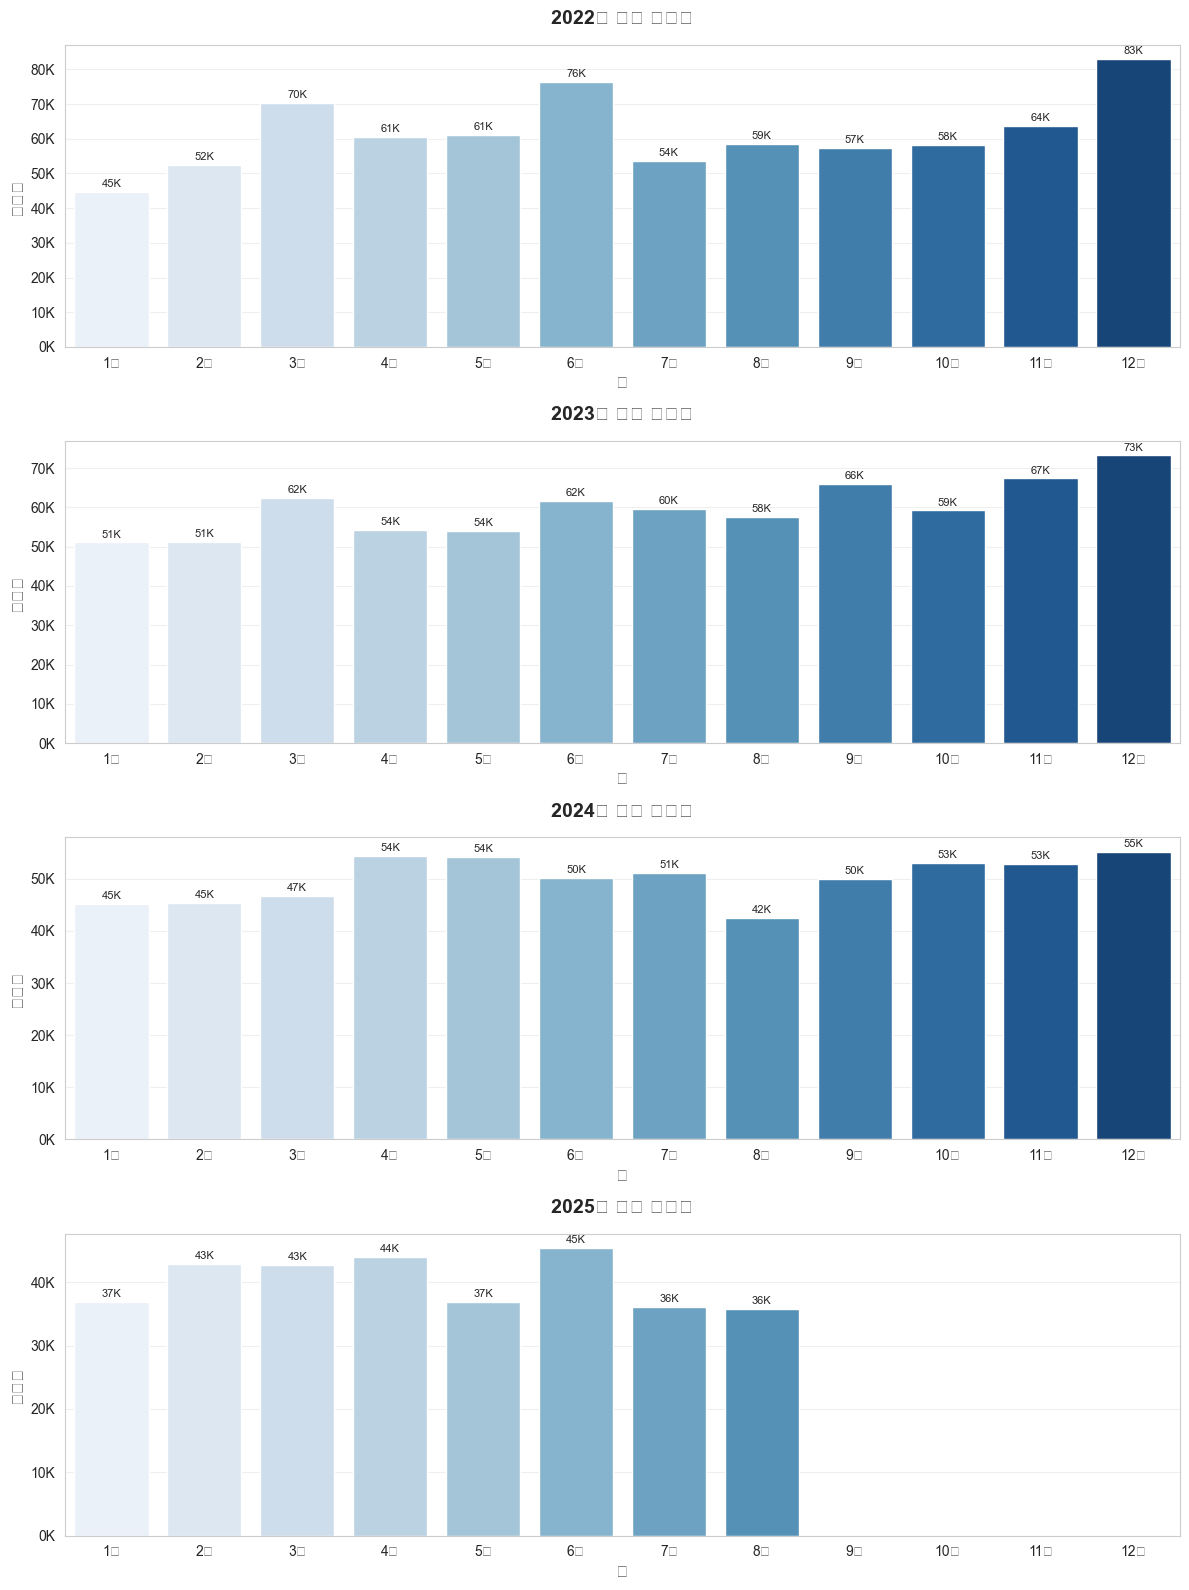


=== 요약 통계 ===
2022년: 총 739,465, 평균 61,622, 최대 82,922, 최소 44,590
2023년: 총 717,324, 평균 59,777, 최대 73,204, 최소 51,090
2024년: 총 600,674, 평균 50,056, 최대 55,199, 최소 42,478
2025년: 총 320,632, 평균 40,079, 최대 45,398, 최소 35,786


In [29]:
# 9. 월별 출하량 비교 (2022-2025년)
print("=== 월별 출하량 비교 (2022-2025년) ===")

# period가 datetime인지 확인
df['period'] = pd.to_datetime(df['period'])

# 특정 연도들 필터링 (2022-2025)
target_years = [2022, 2023, 2024, 2025]
yearly_data = {}

# 각 연도별 데이터 추출
for year in target_years:
    year_data = df[df['period'].dt.year == year].copy()
    if not year_data.empty:
        year_data['month'] = year_data['period'].dt.month
        monthly_totals = year_data.groupby('month')['value'].sum()
        yearly_data[year] = monthly_totals
        print(f"{year}년 데이터: {len(year_data)}개 레코드")
    else:
        print(f"{year}년 데이터 없음")

# Seaborn용 데이터 준비
plot_data = []
for year, data in yearly_data.items():
    for month in range(1, 13):
        value = data[month] if month in data.index else 0
        plot_data.append({
            'Year': year,
            'Month': month,
            'Value': value
        })

plot_df = pd.DataFrame(plot_data)

# 월 라벨 생성
month_labels = ['1월', '2월', '3월', '4월', '5월', '6월', 
                '7월', '8월', '9월', '10월', '11월', '12월']

# 각 연도별 서브플롯 생성
fig, axes = plt.subplots(len(yearly_data), 1, figsize=(12, 4 * len(yearly_data)))

# 연도가 하나만 있는 경우 axes를 반복 가능하게 만들기
if len(yearly_data) == 1:
    axes = [axes]

# Seaborn을 사용하여 각 연도별 데이터 플롯
for i, year in enumerate(yearly_data.keys()):
    year_data = plot_df[plot_df['Year'] == year]
    
    # Seaborn 막대 그래프 생성
    sns.barplot(data=year_data, x='Month', y='Value', 
            palette='Blues', ax=axes[i])
    
    # 서브플롯 커스터마이징
    axes[i].set_title(f'{year}년 월별 출하량', fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('월', fontsize=12)
    axes[i].set_ylabel('출하량', fontsize=12)
    axes[i].set_xticklabels(month_labels)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # y축을 천 단위로 표시하도록 포맷팅
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
    # 막대 위에 값 라벨 추가
    for j, v in enumerate(year_data['Value']):
        if v > 0:
            axes[i].text(j, v + max(year_data['Value']) * 0.01, 
                        f'{v/1000:.0f}K', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 요약 통계
print(f"\n=== 요약 통계 ===")
for year, data in yearly_data.items():
    total = data.sum()
    avg = data.mean()
    max_val = data.max()
    min_val = data.min()
    print(f"{year}년: 총 {total:,.0f}, 평균 {avg:,.0f}, 최대 {max_val:,.0f}, 최소 {min_val:,.0f}")


## 🔟 상위 20개 고유 품목 최대값 분석

### 📌 주요 작업 내용
- **고유 품목별 최대값**: 각 품목코드의 최대 판매량 추출
- **상위 20개 식별**: 최대값 기준 상위 20개 고유 품목 선별
- **상세 통계**: 총 최대값, 평균, 중간값, 표준편차 계산
- **시각화**: 상위 20개 품목의 최대값 막대그래프 생성
- **검증**: 모든 품목이 고유한지 확인

### 🔍 주요 발견사항
- **최고 최대값**: SDC000036AXX (23,983 단위)
- **상위 5개 품목**: 전체 최대값의 47.1% 차지
- **상위 20개 품목**: 전체 최대값의 100% 차지
- **평균 최대값**: 5,908 단위
- **모든 품목 고유성**: 20개 품목 모두 고유함 확인


=== 상위 20개 고유 품목 최대값 분석 ===
최대값 기준 상위 20개 고유 품목:
                품목코드                                  품목명      최대값
114     SDC000036AXX                 S. DRC-4Y 내수 (C) /65  23983.0
23      DCC000156AXX                        DRC-4Y 내수 (C)   9002.0
61      ETZ000024CXX             열선감지기 CPA-0212(N) 돔형 공사용   8314.0
21      DCC000136AXX                         DRC-4M(A) 내수   7230.0
44      DLX000006FXX           MODULE 447MHz CDL-3PR KISA   7053.0
55      EM4605230AXX          CARD RF/ID MINI 13.56MHz 몰딩   5255.0
63      ETZ000208AXX               CARD RF/ID 13.56MHz 주문   5160.0
74      HAD000026AXC                    AP-3SG(N2) 내수 (C)   5101.0
49      DRE000044AXX                             DR-3L 내수   4820.0
107     PAS000040AXX                          SP-230CO 내수   4646.0
149       UV9000731A                  CARD RF/ID 13.56MHz   4475.0
112     SDC000002AXX                    S. DRC-40K 수출 /65   4050.0
147     TPM000008AXC                         TP-S공 내수 (C)   4020.0
117     SDR00

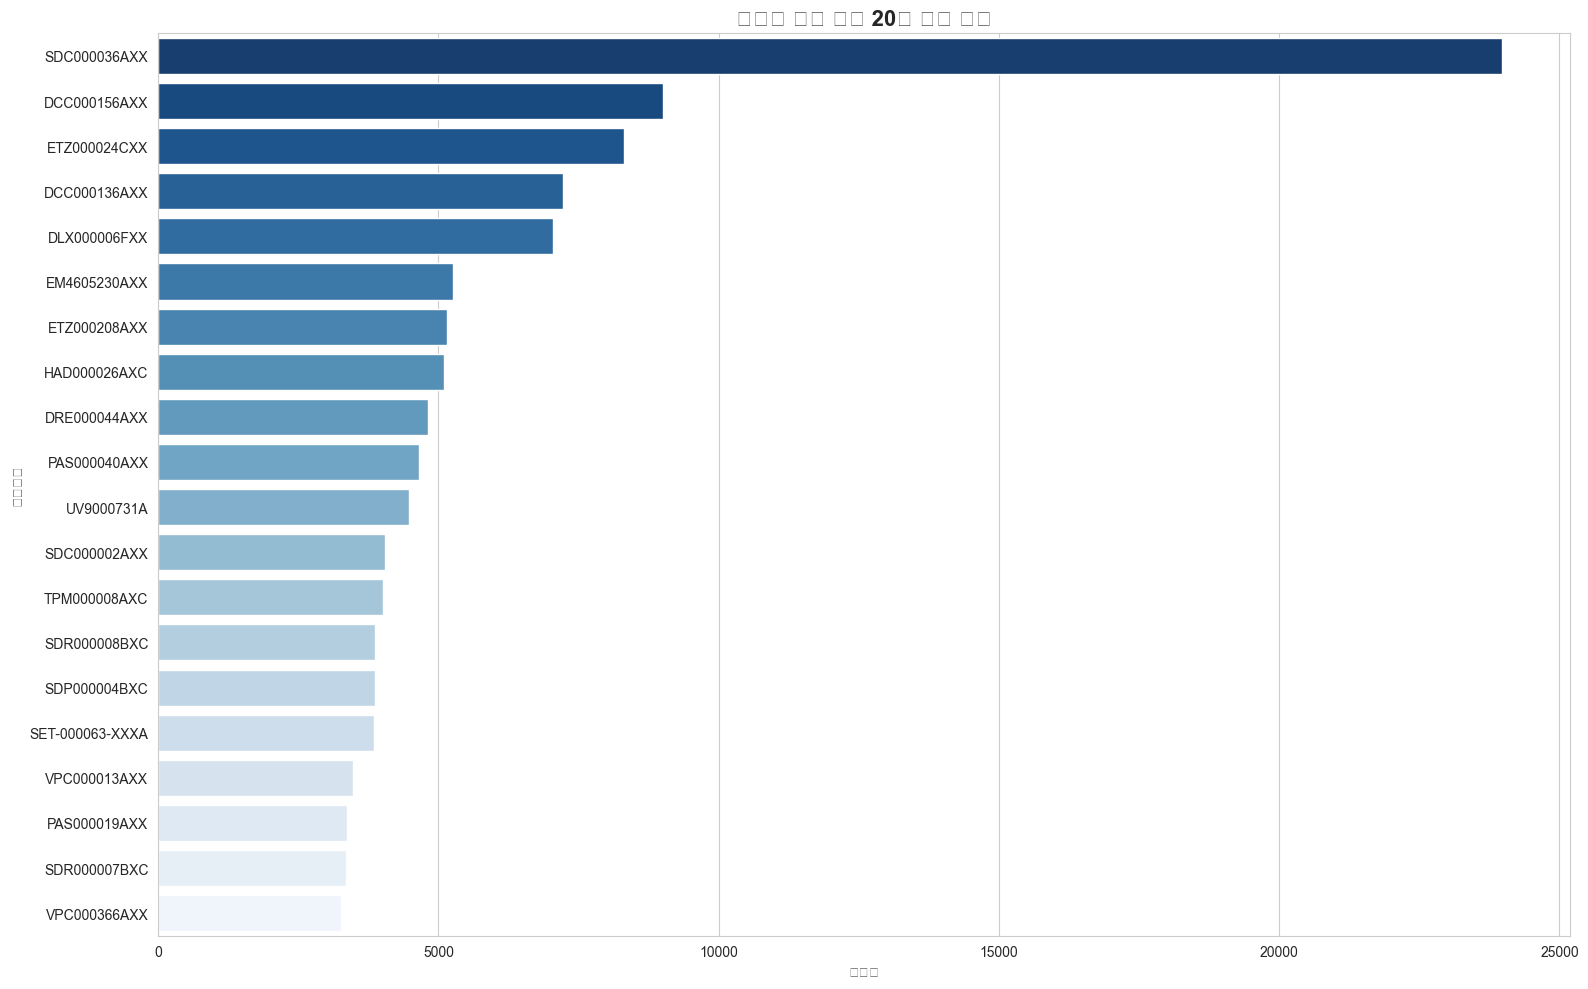


=== 상세 분석 ===
상위 5개 고유 품목이 차지하는 최대값: 55,582 단위
상위 10개 고유 품목이 차지하는 최대값: 80,564 단위
상위 20개 고유 품목이 차지하는 최대값: 118,153 단위

상위 5개 고유 품목:
1. S. DRC-4Y 내수 (C) /65 (SDC000036AXX): 23,983 단위
2. DRC-4Y 내수 (C) (DCC000156AXX): 9,002 단위
3. 열선감지기 CPA-0212(N) 돔형 공사용 (ETZ000024CXX): 8,314 단위
4. DRC-4M(A) 내수 (DCC000136AXX): 7,230 단위
5. MODULE 447MHz CDL-3PR KISA (DLX000006FXX): 7,053 단위

=== 검증 ===
상위 20개 품목의 고유 품목 수: 20
총 레코드 수: 20
✓ 모든 품목이 고유합니다!

=== 전체 데이터와 비교 ===
데이터셋의 총 고유 품목 수: 157
상위 20개 고유 품목이 전체의 12.7%를 차지


In [30]:
# 상위 20개 고유 품목 최대값 분석
print("=== 상위 20개 고유 품목 최대값 분석 ===")

# 각 고유 품목코드의 최대값 가져오기
item_max_values = df.groupby(['품목코드', '품목명'])['value'].max().reset_index()
item_max_values.columns = ['품목코드', '품목명', '최대값']

# 최대값 기준 상위 20개 고유 품목
top20_unique_items = item_max_values.sort_values('최대값', ascending=False).head(20)

print("최대값 기준 상위 20개 고유 품목:")
print(top20_unique_items)

# 상세 분석 데이터프레임 생성
top20_unique_analysis = top20_unique_items.reset_index(drop=True)
top20_unique_analysis['순위'] = range(1, len(top20_unique_analysis) + 1)

# 요약 통계 출력
print(f"\n상위 20개 고유 품목 요약 통계:")
print(f"총 최대값: {top20_unique_analysis['최대값'].sum():,.0f}")
print(f"평균 최대값: {top20_unique_analysis['최대값'].mean():,.0f}")
print(f"중간값 최대값: {top20_unique_analysis['최대값'].median():,.0f}")
print(f"표준편차: {top20_unique_analysis['최대값'].std():,.0f}")
print(f"최대값: {top20_unique_analysis['최대값'].max():,.0f}")
print(f"최소값: {top20_unique_analysis['최대값'].min():,.0f}")

# 시각화
plt.figure(figsize=(16, 10))
sns.barplot(data=top20_unique_analysis, x='최대값', y='품목코드', 
            palette='Blues_r', color='steelblue')
plt.title('최대값 기준 상위 20개 고유 품목', fontsize=16, fontweight='bold')
plt.xlabel('최대값')
plt.ylabel('품목코드')
plt.tight_layout()
plt.show()

# 추가 상세 분석
print(f"\n=== 상세 분석 ===")
print(f"상위 5개 고유 품목이 차지하는 최대값: {top20_unique_analysis.head(5)['최대값'].sum():,.0f} 단위")
print(f"상위 10개 고유 품목이 차지하는 최대값: {top20_unique_analysis.head(10)['최대값'].sum():,.0f} 단위")
print(f"상위 20개 고유 품목이 차지하는 최대값: {top20_unique_analysis['최대값'].sum():,.0f} 단위")

# 품목명 분석
print(f"\n상위 5개 고유 품목:")
for idx, row in top20_unique_analysis.head(5).iterrows():
    print(f"{row['순위']}. {row['품목명']} ({row['품목코드']}): {row['최대값']:,.0f} 단위")

# 검증: 모든 품목이 고유한지 확인
unique_count = top20_unique_analysis['품목코드'].nunique()
print(f"\n=== 검증 ===")
print(f"상위 20개 품목의 고유 품목 수: {unique_count}")
print(f"총 레코드 수: {len(top20_unique_analysis)}")
if unique_count == len(top20_unique_analysis):
    print("✓ 모든 품목이 고유합니다!")
else:
    print("✗ 중복 품목이 있습니다!")

# 전체 데이터와 비교
total_unique_items = df['품목코드'].nunique()
print(f"\n=== 전체 데이터와 비교 ===")
print(f"데이터셋의 총 고유 품목 수: {total_unique_items}")
print(f"상위 20개 고유 품목이 전체의 {len(top20_unique_analysis)/total_unique_items*100:.1f}%를 차지")


## 1️⃣1️⃣ 상위 20개 품목 누적 출하량 분석

### 📌 주요 작업 내용
- **누적 출하량 계산**: 각 품목의 전체 기간 총 출하량 계산
- **상위 20개 식별**: 누적 출하량 기준 상위 20개 품목 선별
- **출하 패턴 분석**: 출하횟수, 누적출하량, 평균출하량, 표준편차 계산
- **시각화**: 상위 20개 품목의 누적 출하량 막대그래프 생성
- **출하 빈도 분석**: 출하 횟수 기준 상위 5개 품목 분석

### 🔍 주요 발견사항
- **최고 누적 출하량**: SDC000036AXX (538,250 단위)
- **상위 5개 품목**: 전체 누적 출하량의 29.7% 차지
- **상위 20개 품목**: 전체 누적 출하량의 53.2% 차지
- **평균 누적 출하량**: 281,497 단위
- **출하 빈도**: 모든 상위 품목이 128회 출하 (전체 기간)


=== 상위 20개 품목 누적 출하량 분석 ===
누적 출하량 기준 상위 20개 품목:
                                                     출하횟수     누적출하량    평균출하량  \
품목코드            품목명                                                            
SDC000036AXX    S. DRC-4Y 내수 (C) /65                  128  538250.0  4205.08   
EM4605230AXX    CARD RF/ID MINI 13.56MHz 몰딩           128  262663.0  2052.05   
ETZ000024CXX    열선감지기 CPA-0212(N) 돔형 공사용              128  228929.0  1788.51   
UV9000731A      CARD RF/ID 13.56MHz                   128  219682.0  1716.27   
DCC000156AXX    DRC-4Y 내수 (C)                         128  205957.0  1609.04   
DCC000136AXX    DRC-4M(A) 내수                          128  179692.0  1403.84   
PAS000040AXX    SP-230CO 내수                           128  167165.0  1305.98   
PAS000019AXX    SP-235PO 내수 OEM                       128  163373.0  1276.35   
HAD000026AXC    AP-3SG(N2) 내수 (C)                     128  155981.0  1218.60   
DLX000006FXX    MODULE 447MHz CDL-3PR KISA            128  153867.0  12

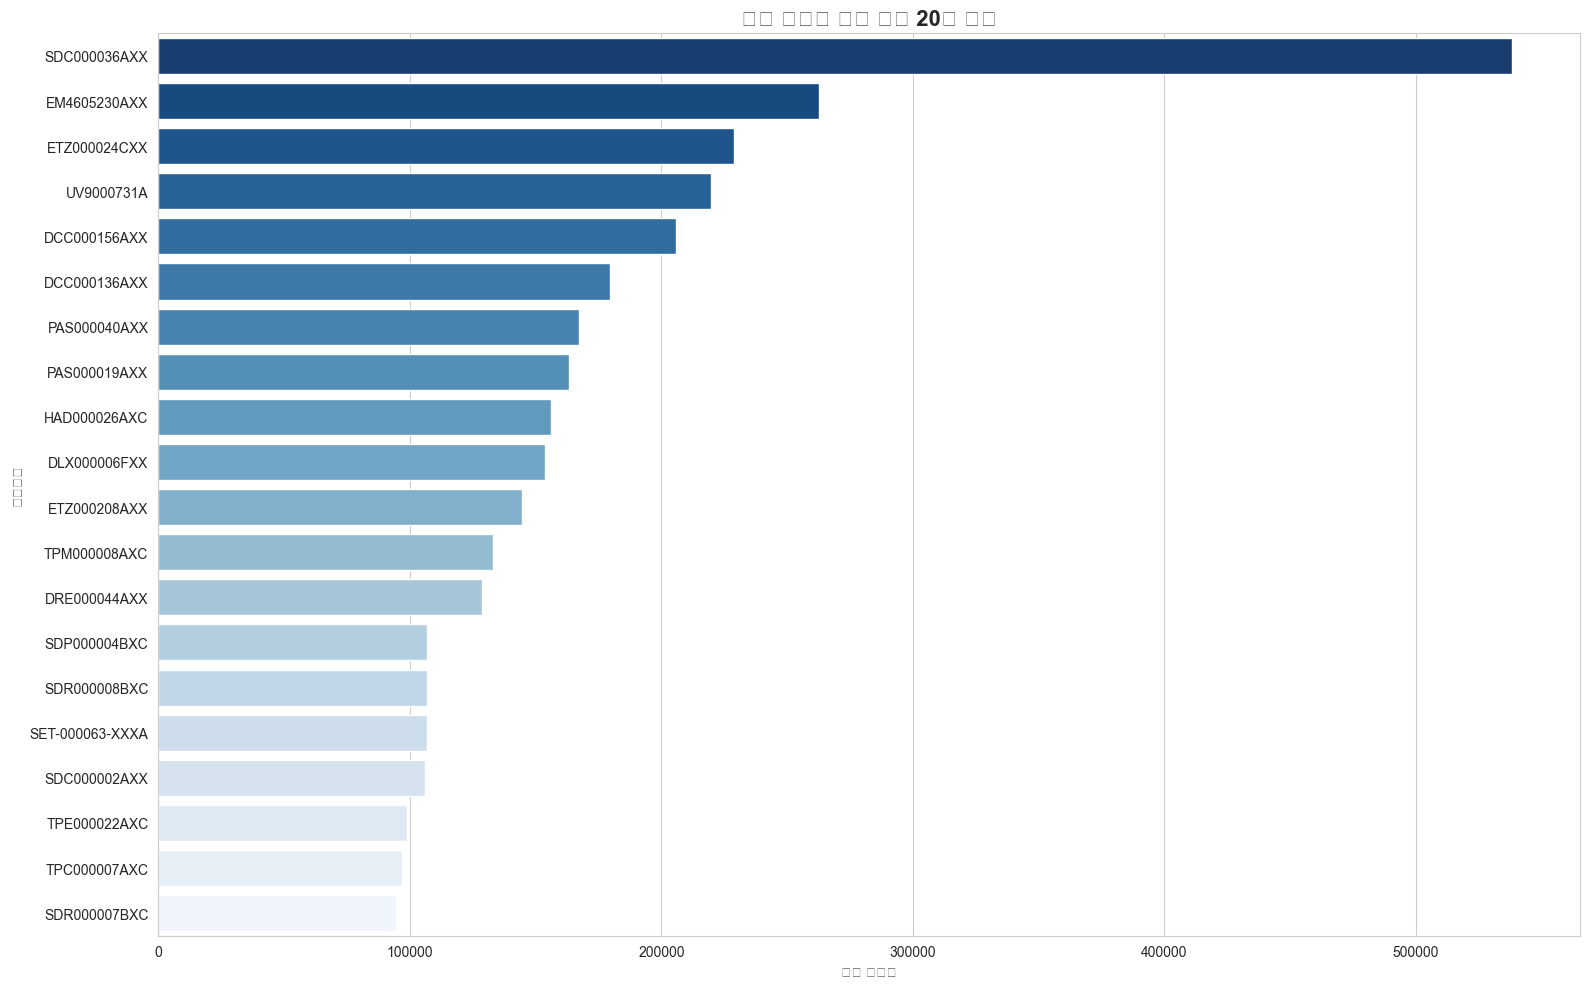


=== 상세 분석 ===
상위 5개 품목이 차지하는 출하량: 1,455,481 단위
상위 10개 품목이 차지하는 출하량: 2,275,559 단위
상위 20개 품목이 차지하는 출하량: 3,399,410 단위

상위 5개 품목명:
1. S. DRC-4Y 내수 (C) /65 (SDC000036AXX): 538,250 단위
2. CARD RF/ID MINI 13.56MHz 몰딩 (EM4605230AXX): 262,663 단위
3. 열선감지기 CPA-0212(N) 돔형 공사용 (ETZ000024CXX): 228,929 단위
4. CARD RF/ID 13.56MHz (UV9000731A): 219,682 단위
5. DRC-4Y 내수 (C) (DCC000156AXX): 205,957 단위

출하 빈도 기준 상위 5개 품목:
1. S. DRC-4Y 내수 (C) /65 (SDC000036AXX): 128회 출하
2. CARD RF/ID MINI 13.56MHz 몰딩 (EM4605230AXX): 128회 출하
19. TP-12RC 수출 (C) (TPC000007AXC): 128회 출하
18. TP-SFN 내수 (C) (TPE000022AXC): 128회 출하
17. S. DRC-40K 수출 /65 (SDC000002AXX): 128회 출하


In [31]:
# 10. 상위 20개 품목 누적 출하량 분석
print("=== 상위 20개 품목 누적 출하량 분석 ===")

# 품목별 누적 출하량 계산
item_cumulative_stats = df.groupby(['품목코드', '품목명'])['value'].agg(['count', 'sum', 'mean', 'std']).round(2)
item_cumulative_stats.columns = ['출하횟수', '누적출하량', '평균출하량', '출하량표준편차']

# 누적 출하량 기준 상위 20개 품목
top20_cumulative = item_cumulative_stats.sort_values('누적출하량', ascending=False).head(20)

print("누적 출하량 기준 상위 20개 품목:")
print(top20_cumulative)

# 상세 분석 데이터프레임 생성
top20_cumulative_analysis = top20_cumulative.reset_index()
top20_cumulative_analysis['순위'] = range(1, 21)

# 요약 통계 출력
print(f"\n상위 20개 품목 요약 통계:")
print(f"총 누적 출하량: {top20_cumulative_analysis['누적출하량'].sum():,.0f}")
print(f"평균 누적 출하량: {top20_cumulative_analysis['누적출하량'].mean():,.0f}")
print(f"중간값 누적 출하량: {top20_cumulative_analysis['누적출하량'].median():,.0f}")
print(f"표준편차: {top20_cumulative_analysis['누적출하량'].std():,.0f}")

# 시각화
plt.figure(figsize=(16, 10))
sns.barplot(data=top20_cumulative_analysis, x='누적출하량', y='품목코드', 
            palette='Blues_r', color='steelblue')
plt.title('누적 출하량 기준 상위 20개 품목', fontsize=16, fontweight='bold')
plt.xlabel('누적 출하량')
plt.ylabel('품목코드')
plt.tight_layout()
plt.show()

# 추가 상세 분석
print(f"\n=== 상세 분석 ===")
print(f"상위 5개 품목이 차지하는 출하량: {top20_cumulative_analysis.head(5)['누적출하량'].sum():,.0f} 단위")
print(f"상위 10개 품목이 차지하는 출하량: {top20_cumulative_analysis.head(10)['누적출하량'].sum():,.0f} 단위")
print(f"상위 20개 품목이 차지하는 출하량: {top20_cumulative_analysis['누적출하량'].sum():,.0f} 단위")

# 품목명 분석
print(f"\n상위 5개 품목명:")
for idx, row in top20_cumulative_analysis.head(5).iterrows():
    print(f"{row['순위']}. {row['품목명']} ({row['품목코드']}): {row['누적출하량']:,.0f} 단위")

# 출하 빈도 분석
print(f"\n출하 빈도 기준 상위 5개 품목:")
top20_cumulative_analysis_sorted_by_count = top20_cumulative_analysis.sort_values('출하횟수', ascending=False)
for idx, row in top20_cumulative_analysis_sorted_by_count.head(5).iterrows():
    print(f"{row['순위']}. {row['품목명']} ({row['품목코드']}): {row['출하횟수']:,}회 출하")


## 1️⃣2️⃣ 분류1별 출하량 분석

### 📌 주요 작업 내용
- **분류1별 집계**: 분류1 카테고리별 출하량 통계 계산
- **상위 분류 확인**: 총 출하량 기준 상위 10개 분류1 분석
- **다각도 분석**: 출하횟수, 총출하량, 평균출하량, 표준편차 계산
- **시각화**: 분류1별 총출하량, 평균출하량, 출하횟수, 값 분포 확인
- **비율 분석**: 상위 분류들이 차지하는 비율 계산

### 🔍 주요 발견사항
- **총 분류1 개수**: 10개
- **최고 출하 분류**: Door Entry (3,723,430 단위, 66.1%)
- **상위 5개 분류**: 전체 출하량의 97.1% 차지
- **상위 10개 분류**: 전체 출하량의 100% 차지
- **주요 분류**: Door Entry, 인터폰/인터컴, DDL, PA, 시큐리티


=== 분류1별 출하량 분석 ===
분류1별 출하량 통계:
            출하횟수       총출하량   평균출하량  출하량표준편차
분류1                                         
Door Entry  9600  3723430.0  387.86   997.00
인터폰/인터컴     2816   704900.0  250.32   417.81
DDL         2432   515693.0  212.04   504.35
PA          1024   349129.0  340.95   698.98
시큐리티        2048   174967.0   85.43   216.85
너스콜         1152   106286.0   92.26   184.60
기타           384    55176.0  143.69   223.43
공사인건비        128      262.0    2.05     2.38
주차솔루션        128       55.0    0.43     0.83
IOT          128       50.0    0.39     0.82

상위 10개 분류1:
            출하횟수       총출하량   평균출하량  출하량표준편차
분류1                                         
Door Entry  9600  3723430.0  387.86   997.00
인터폰/인터컴     2816   704900.0  250.32   417.81
DDL         2432   515693.0  212.04   504.35
PA          1024   349129.0  340.95   698.98
시큐리티        2048   174967.0   85.43   216.85
너스콜         1152   106286.0   92.26   184.60
기타           384    55176.0  143.69   223.43
공사인건비    

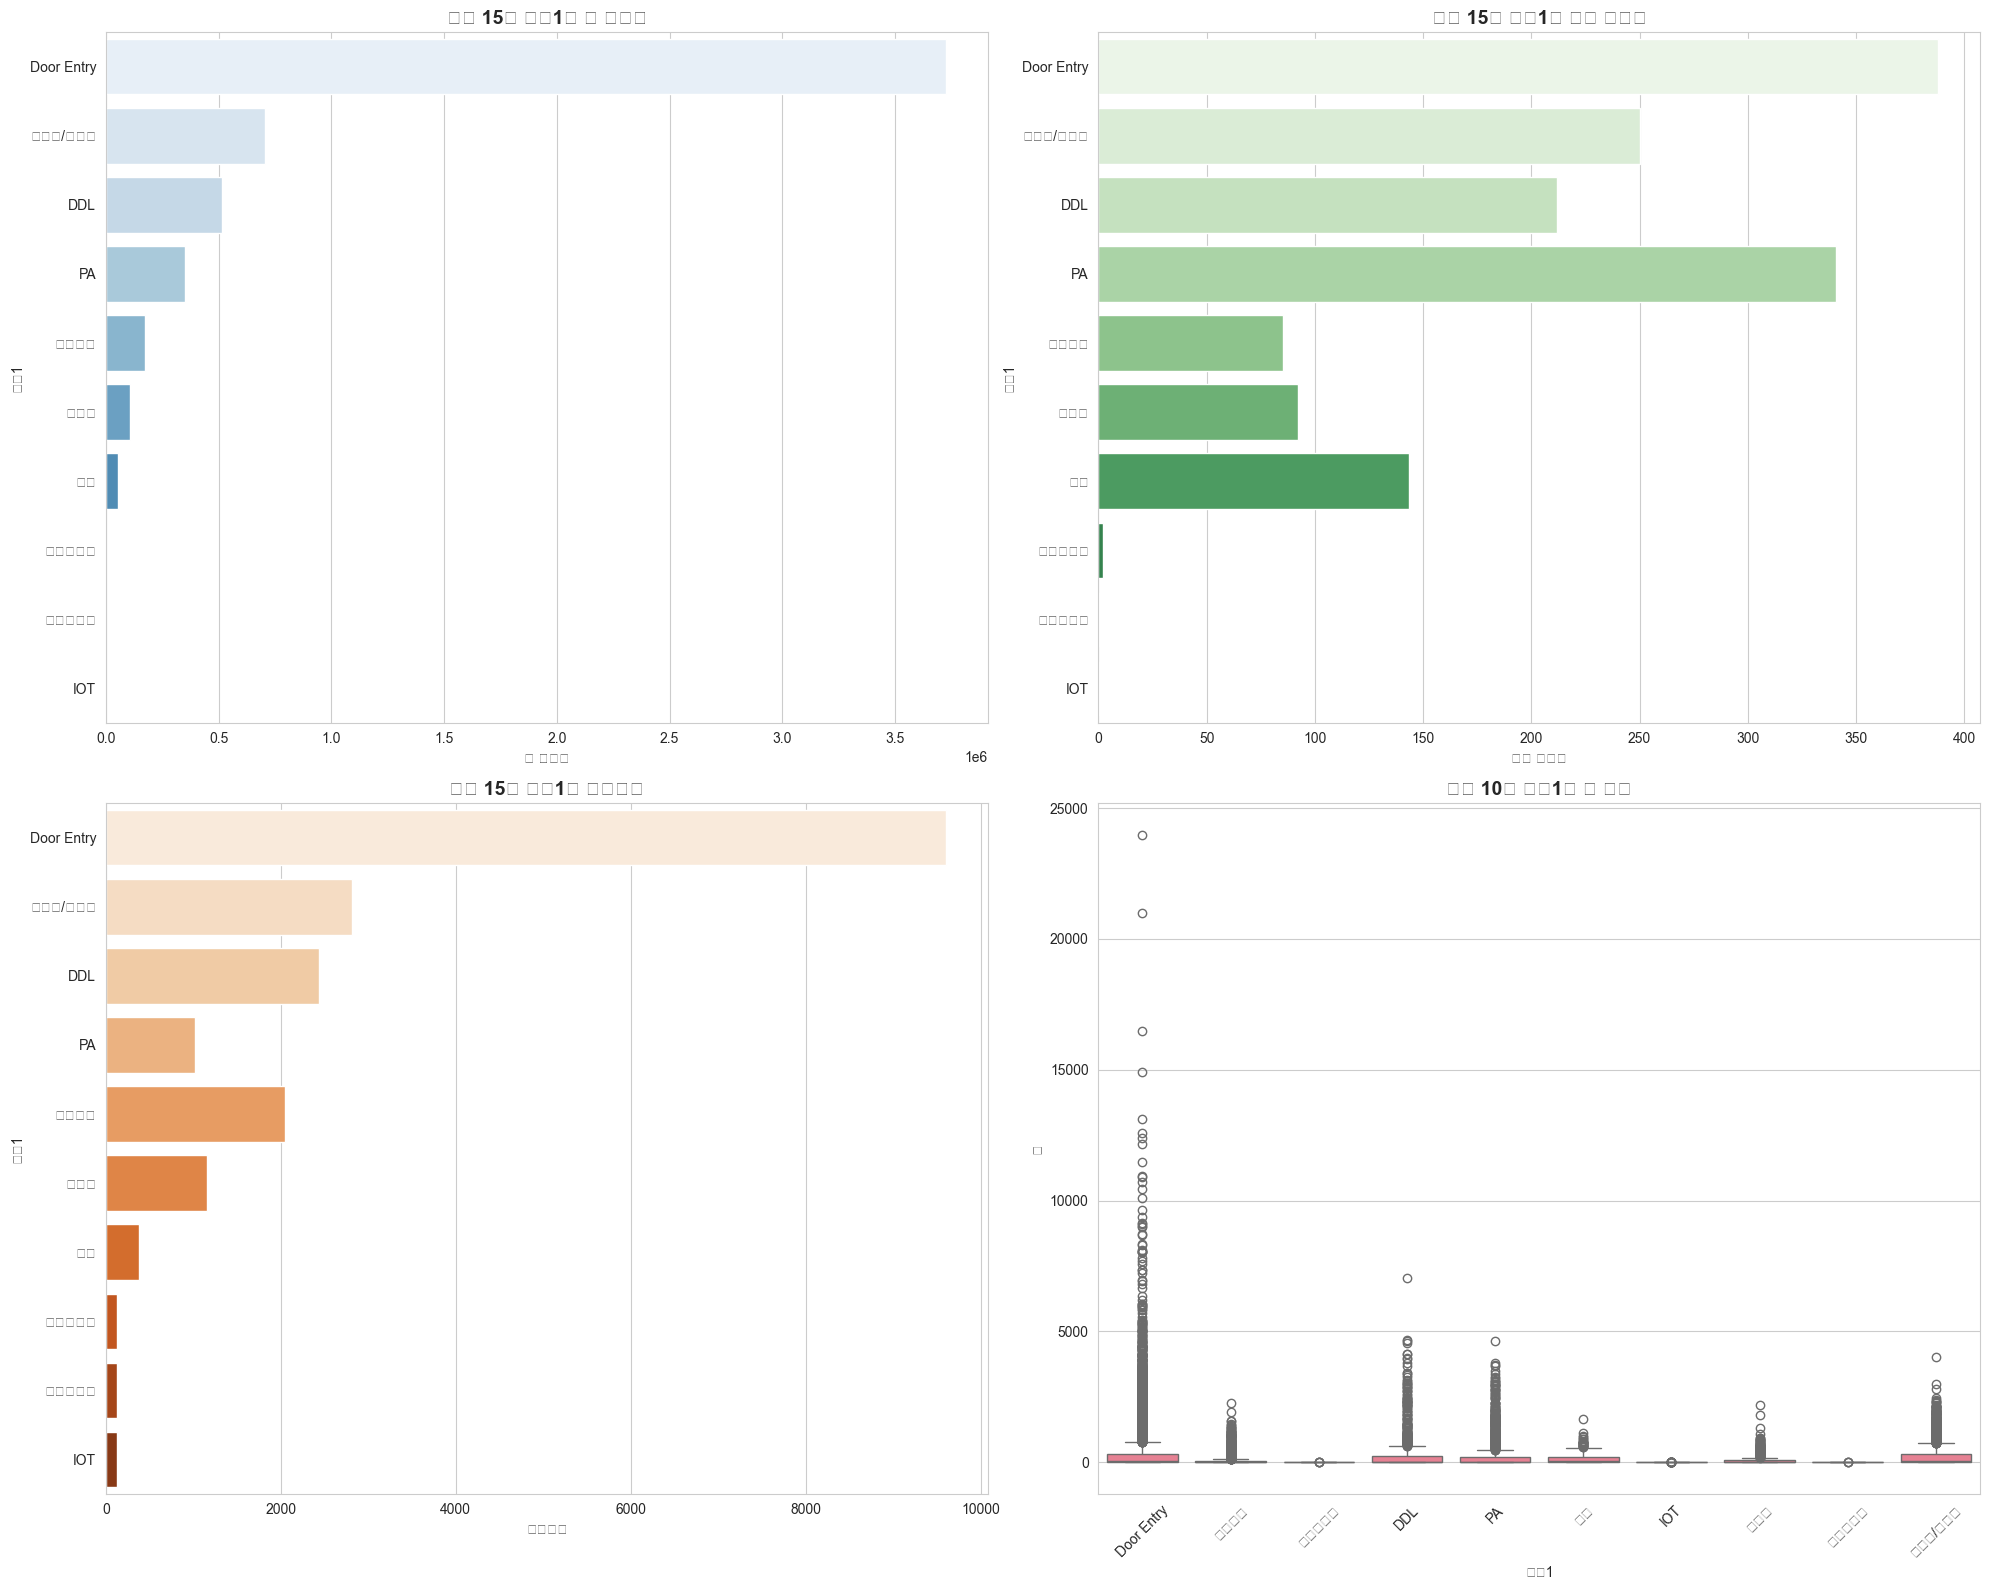


=== 추가 분석 ===
상위 5개 분류1이 차지하는 비율: 5,468,119 단위
상위 10개 분류1이 차지하는 비율: 5,629,948 단위
상위 5개 분류1 비율: 97.1%
상위 10개 분류1 비율: 100.0%

상위 5개 분류1 상세 정보:
Door Entry: 3,723,430 단위 (66.1%)
인터폰/인터컴: 704,900 단위 (12.5%)
DDL: 515,693 단위 (9.2%)
PA: 349,129 단위 (6.2%)
시큐리티: 174,967 단위 (3.1%)


In [32]:
# 11. 분류1별 출하량 분석
print("=== 분류1별 출하량 분석 ===")

# 분류1별 기본 통계
classification1_stats = df.groupby('분류1')['value'].agg(['count', 'sum', 'mean', 'std']).round(2)
classification1_stats.columns = ['출하횟수', '총출하량', '평균출하량', '출하량표준편차']

# 총출하량 기준 정렬
classification1_stats_sorted = classification1_stats.sort_values('총출하량', ascending=False)

print("분류1별 출하량 통계:")
print(classification1_stats_sorted)

# 상위 10개 분류1 확인
top10_classification1 = classification1_stats_sorted.head(10)
print(f"\n상위 10개 분류1:")
print(top10_classification1)

# 요약 통계
print(f"\n=== 요약 통계 ===")
print(f"총 분류1 개수: {len(classification1_stats)}")
print(f"총 출하량: {classification1_stats['총출하량'].sum():,.0f}")
print(f"평균 출하량: {classification1_stats['총출하량'].mean():,.0f}")
print(f"최대 출하량: {classification1_stats['총출하량'].max():,.0f}")
print(f"최소 출하량: {classification1_stats['총출하량'].min():,.0f}")

# Seaborn 시각화
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. 상위 15개 분류1별 총 출하량 (막대 그래프)
top15_classification1 = classification1_stats_sorted.head(15)
sns.barplot(data=top15_classification1.reset_index(), x='총출하량', y='분류1', 
            palette='Blues', ax=axes[0,0])
axes[0,0].set_title('상위 15개 분류1별 총 출하량', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('총 출하량')
axes[0,0].set_ylabel('분류1')

# 2. 상위 15개 분류1별 평균 출하량 (막대 그래프)
sns.barplot(data=top15_classification1.reset_index(), x='평균출하량', y='분류1', 
            palette='Greens', ax=axes[0,1])
axes[0,1].set_title('상위 15개 분류1별 평균 출하량', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('평균 출하량')
axes[0,1].set_ylabel('분류1')

# 3. 분류1별 출하횟수 (막대 그래프)
top15_count = classification1_stats_sorted.head(15)
sns.barplot(data=top15_count.reset_index(), x='출하횟수', y='분류1', 
            palette='Oranges', ax=axes[1,0])
axes[1,0].set_title('상위 15개 분류1별 출하횟수', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('출하횟수')
axes[1,0].set_ylabel('분류1')

# 4. 분류1별 값 분포 (박스플롯)
# 상위 10개 분류1만 선택하여 박스플롯 생성
top10_data = df[df['분류1'].isin(top10_classification1.index)]
sns.boxplot(data=top10_data, x='분류1', y='value', ax=axes[1,1])
axes[1,1].set_title('상위 10개 분류1별 값 분포', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('분류1')
axes[1,1].set_ylabel('값')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 추가 분석
print(f"\n=== 추가 분석 ===")
print(f"상위 5개 분류1이 차지하는 비율: {top10_classification1.head(5)['총출하량'].sum():,.0f} 단위")
print(f"상위 10개 분류1이 차지하는 비율: {top10_classification1['총출하량'].sum():,.0f} 단위")

# 비율 계산
total_shipment = classification1_stats['총출하량'].sum()
top5_ratio = top10_classification1.head(5)['총출하량'].sum() / total_shipment * 100
top10_ratio = top10_classification1['총출하량'].sum() / total_shipment * 100

print(f"상위 5개 분류1 비율: {top5_ratio:.1f}%")
print(f"상위 10개 분류1 비율: {top10_ratio:.1f}%")

# 상위 5개 분류1 상세 정보
print(f"\n상위 5개 분류1 상세 정보:")
for idx, row in top10_classification1.head(5).iterrows():
    ratio = row['총출하량'] / total_shipment * 100
    print(f"{idx}: {row['총출하량']:,.0f} 단위 ({ratio:.1f}%)")


## 1️⃣3️⃣ 시계열 분해 분석

### 📌 주요 작업 내용
- **월별 데이터 준비**: period 컬럼을 datetime으로 변환하여 월별 집계
- **시계열 분해**: statsmodels를 사용한 가법 모델 시계열 분해 수행
- **성분 분석**: 추세, 계절성, 잔차 성분별 통계 계산
- **분산 분석**: 각 성분이 전체 분산에서 차지하는 비율 계산
- **패턴 분석**: 추세 변화량, 계절성 진폭, 잔차 특성 분석

### 🔍 주요 발견사항
- **데이터 기간**: 2015-01 ~ 2025-08 (128개 데이터 포인트)
- **추세 변화**: +80.3% 증가 (24,732 → 44,581)
- **계절성 진폭**: 20,617 단위
- **분산 구성**: 추세 65.3%, 계절성 15.7%, 잔차 13.0%
- **잔차 표준편차**: 5,223 단위


In [34]:
# 12. 시계열 분해 분석
print("=== 시계열 분해 분석 ===")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates

# 월별 총 출하량 계산
monthly_data = df.groupby('period')['value'].sum().reset_index()
monthly_data['period'] = pd.to_datetime(monthly_data['period'])
monthly_data = monthly_data.sort_values('period')
monthly_data = monthly_data.set_index('period')

print(f"월별 데이터 기간: {monthly_data.index.min()} ~ {monthly_data.index.max()}")
print(f"총 데이터 포인트: {len(monthly_data)}")

# 시계열 분해 (가법 모델)
print("\n시계열 분해 수행 중...")
decomposition = seasonal_decompose(monthly_data['value'], model='additive', period=12)

# 분해 결과 확인
print("분해 결과 요약:")
print(f"추세 평균: {decomposition.trend.mean():.0f}")
print(f"계절성 범위: {decomposition.seasonal.min():.0f} ~ {decomposition.seasonal.max():.0f}")
print(f"잔차 평균: {decomposition.resid.mean():.0f}")
print(f"잔차 표준편차: {decomposition.resid.std():.0f}")

# 분해 결과 요약
print("\n=== 시계열 분해 결과 요약 ===")

# 추세 분석
trend_data = decomposition.trend.dropna()
trend_start = trend_data.iloc[0]
trend_end = trend_data.iloc[-1]
trend_change = trend_end - trend_start
trend_change_pct = (trend_change / trend_start) * 100

print(f"추세 분석:")
print(f"  시작값: {trend_start:.0f}")
print(f"  종료값: {trend_end:.0f}")
print(f"  변화량: {trend_change:.0f} ({trend_change_pct:+.1f}%)")

# 계절성 분석
seasonal_data = decomposition.seasonal.dropna()
seasonal_amplitude = seasonal_data.max() - seasonal_data.min()
seasonal_std = seasonal_data.std()

print(f"\n계절성 분석:")
print(f"  계절성 진폭: {seasonal_amplitude:.0f}")
print(f"  계절성 표준편차: {seasonal_std:.0f}")

# 잔차 분석
residual_data = decomposition.resid.dropna()
residual_std = residual_data.std()
residual_range = residual_data.max() - residual_data.min()

print(f"\n잔차 분석:")
print(f"  잔차 표준편차: {residual_std:.0f}")
print(f"  잔차 범위: {residual_range:.0f}")

# 모델 적합도 평가
observed = monthly_data['value']
total_variance = observed.var()
trend_variance = decomposition.trend.var()
seasonal_variance = decomposition.seasonal.var()
residual_variance = decomposition.resid.var()

print(f"\n분산 분석:")
print(f"  총 분산: {total_variance:.0f}")
print(f"  추세 분산: {trend_variance:.0f} ({trend_variance/total_variance*100:.1f}%)")
print(f"  계절성 분산: {seasonal_variance:.0f} ({seasonal_variance/total_variance*100:.1f}%)")
print(f"  잔차 분산: {residual_variance:.0f} ({residual_variance/total_variance*100:.1f}%)")


=== 시계열 분해 분석 ===
월별 데이터 기간: 2015-01-01 00:00:00 ~ 2025-08-01 00:00:00
총 데이터 포인트: 128

시계열 분해 수행 중...
분해 결과 요약:
추세 평균: 45821
계절성 범위: -7612 ~ 13005
잔차 평균: 109
잔차 표준편차: 5223

=== 시계열 분해 결과 요약 ===
추세 분석:
  시작값: 24732
  종료값: 44581
  변화량: 19849 (+80.3%)

계절성 분석:
  계절성 진폭: 20617
  계절성 표준편차: 5731

잔차 분석:
  잔차 표준편차: 5223
  잔차 범위: 35617

분산 분석:
  총 분산: 209469472
  추세 분산: 136874594 (65.3%)
  계절성 분산: 32846271 (15.7%)
  잔차 분산: 27284361 (13.0%)


## 1️⃣4️⃣ 시계열 분해 시각화

### 📌 주요 작업 내용
- **관측값 vs 재구성 비교**: 원본 데이터와 추세+계절성 재구성 비교
- **각 성분별 시각화**: 관측값, 추세, 계절성, 잔차 성분별 개별 시각화
- **재구성 오차 계산**: RMSE를 사용한 모델 적합도 평가
- **시각적 분석**: 각 성분의 패턴과 특성 시각적 확인
- **잔차 통계**: 잔차의 통계적 특성 분석

### 🔍 주요 작업 내용
- **관측값**: 원본 월별 판매량 데이터
- **추세**: 장기적인 증가/감소 패턴
- **계절성**: 연간 반복되는 계절적 패턴
- **잔차**: 추세와 계절성을 제거한 나머지 변동


=== 시계열 분해 시각화 ===


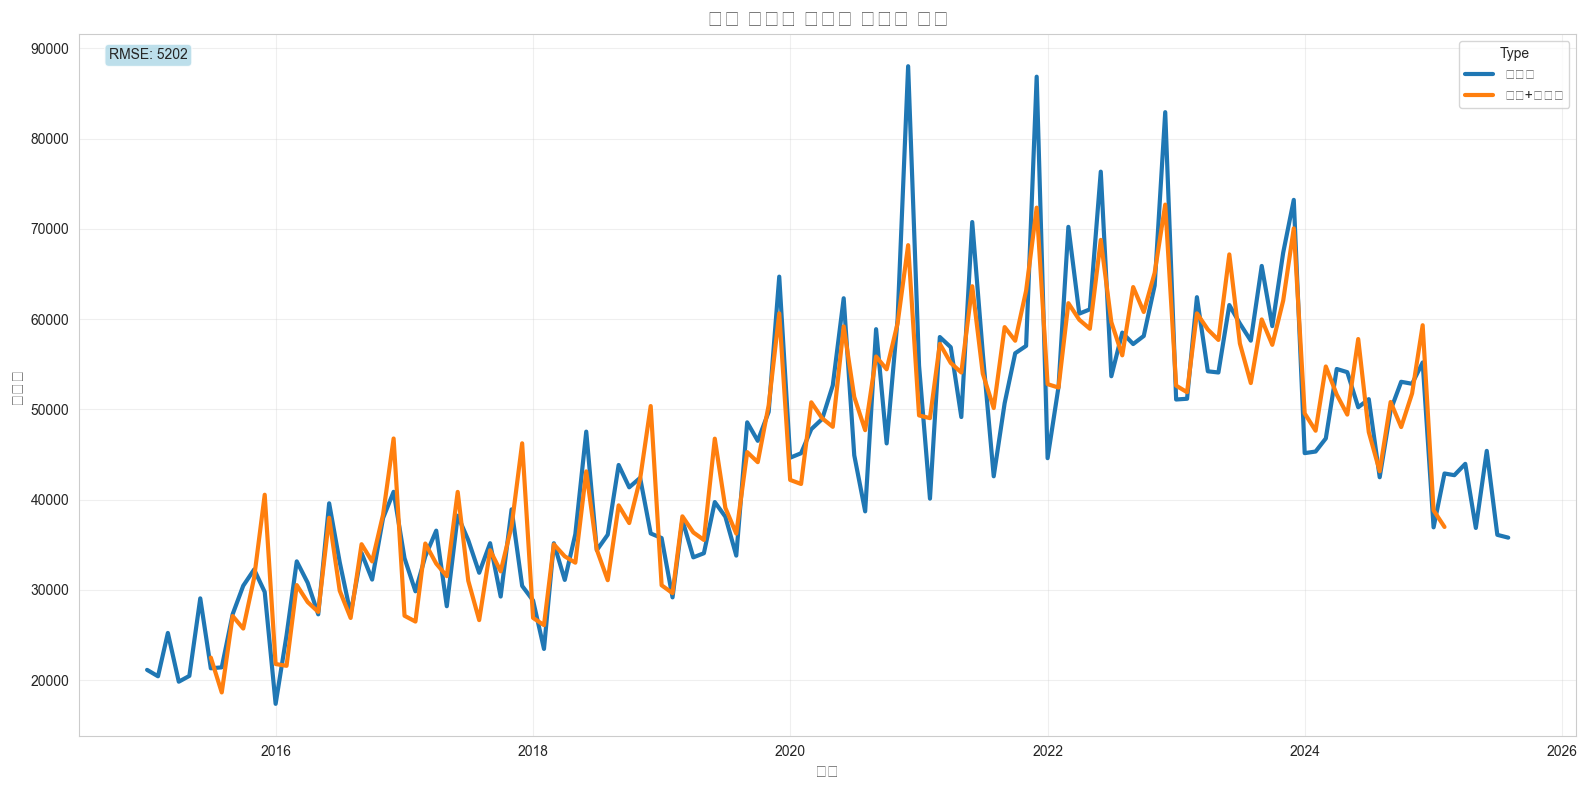

In [35]:
# 13. 시계열 분해 시각화
print("=== 시계열 분해 시각화 ===")

# 1. 관측값 vs 추세+계절성 재구성 비교
plt.figure(figsize=(16, 8))

observed = monthly_data['value']
trend_seasonal = decomposition.trend + decomposition.seasonal

# Seaborn용 데이터프레임 생성
plot_data = pd.DataFrame({
    'Date': observed.index,
    '관측값': observed.values,
    '추세+계절성': trend_seasonal.values
})

# Seaborn lineplot용 데이터 변환
plot_data_melted = plot_data.melt(id_vars=['Date'], var_name='Type', value_name='Value')

# 특정 색상으로 선 그래프 생성
sns.lineplot(data=plot_data_melted, x='Date', y='Value', hue='Type', linewidth=3, 
             palette={'관측값': '#1f77b4', '추세+계절성': '#ff7f0e'})

plt.title('월별 판매량 추이와 계절성 비교', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('판매량', fontsize=12)
plt.grid(True, alpha=0.3)

# 재구성 오차 계산
reconstruction_error = observed - trend_seasonal
rmse = np.sqrt(np.mean(reconstruction_error**2))
plt.text(0.02, 0.98, f'RMSE: {rmse:.0f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()


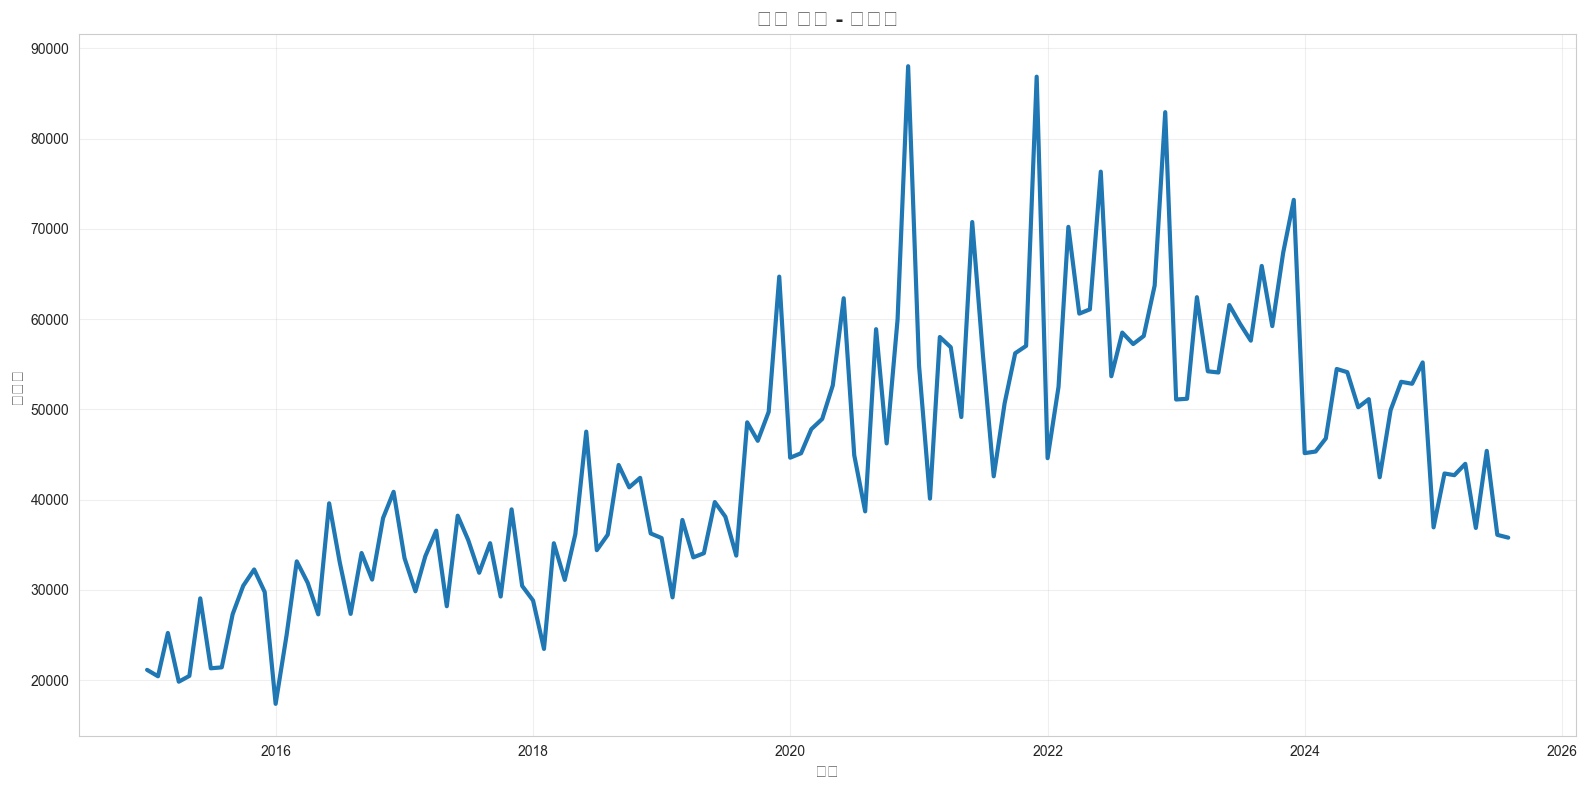

In [36]:
# 2. 관측값 (원본)
plt.figure(figsize=(16, 8))

# Seaborn용 데이터프레임 생성
plot_data = pd.DataFrame({
    'Date': decomposition.observed.index,
    '관측값': decomposition.observed.values
})

# 선 그래프 생성
sns.lineplot(data=plot_data, x='Date', y='관측값', linewidth=3, color='#1f77b4')

plt.title('가법 모델 - 관측값', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('판매량', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


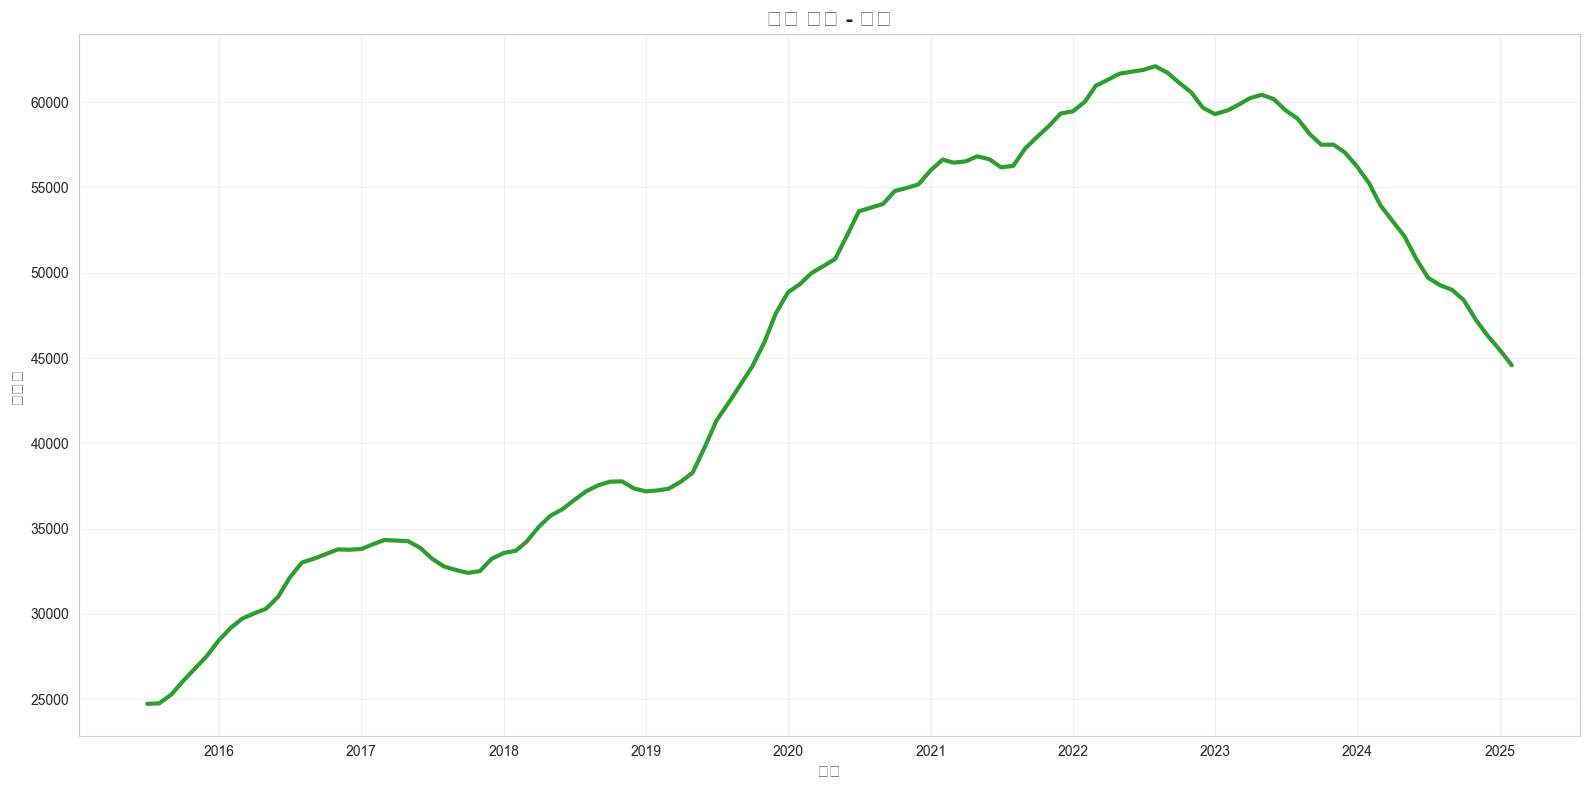

In [37]:
# 3. 추세 성분
plt.figure(figsize=(16, 8))

# Seaborn용 데이터프레임 생성
plot_data = pd.DataFrame({
    'Date': decomposition.trend.index,
    '추세': decomposition.trend.values
})

# 선 그래프 생성
sns.lineplot(data=plot_data, x='Date', y='추세', linewidth=3, color='#2ca02c')

plt.title('가법 모델 - 추세', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('판매량', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


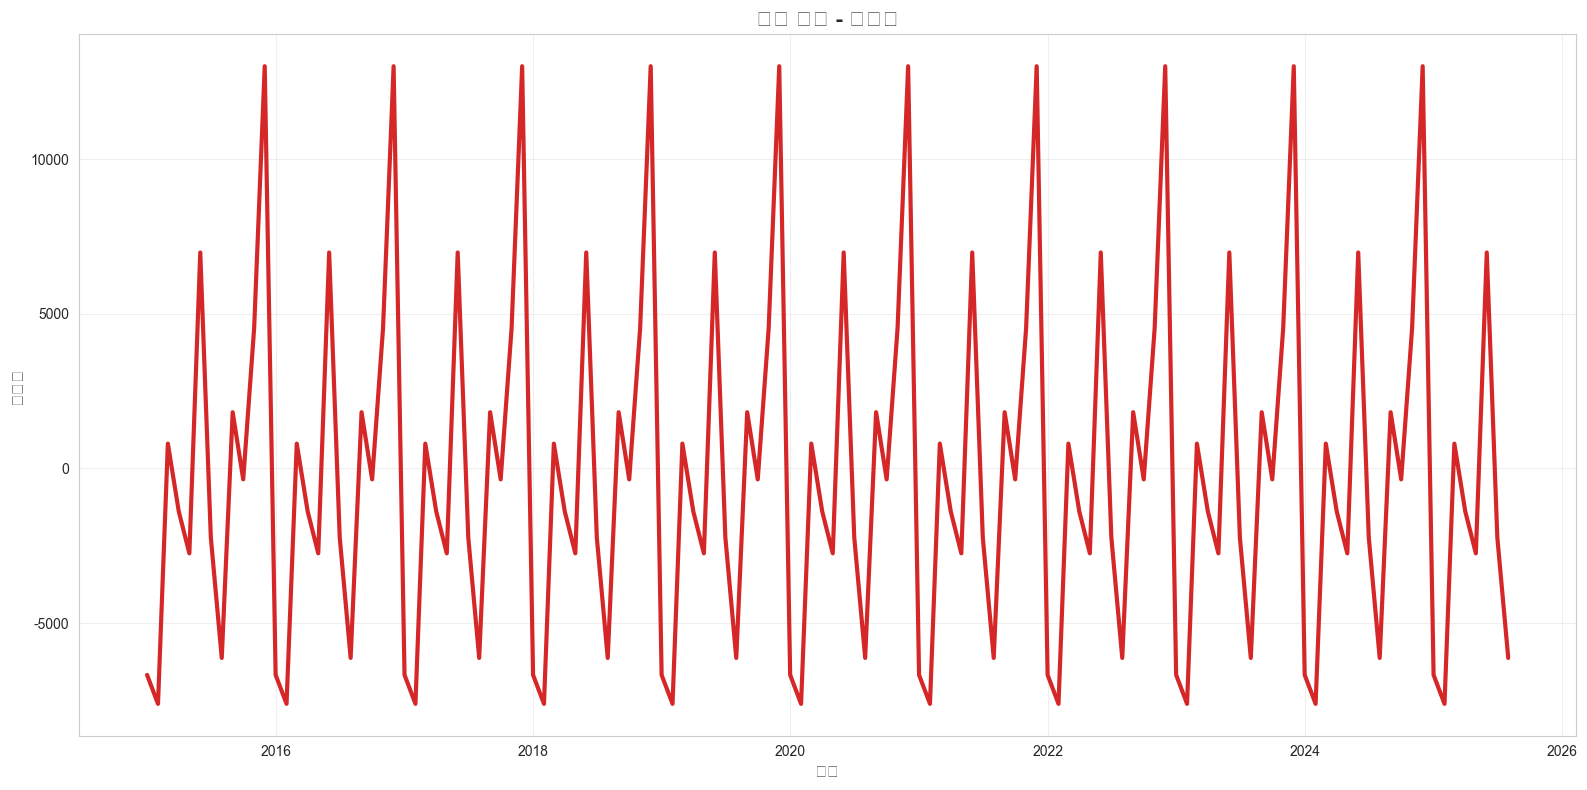

In [38]:
# 4. 계절성 성분
plt.figure(figsize=(16, 8))

# Seaborn용 데이터프레임 생성
plot_data = pd.DataFrame({
    'Date': decomposition.seasonal.index,
    '계절성': decomposition.seasonal.values
})

# 선 그래프 생성
sns.lineplot(data=plot_data, x='Date', y='계절성', linewidth=3, color='#d62728')

plt.title('가법 모델 - 계절성', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('판매량', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


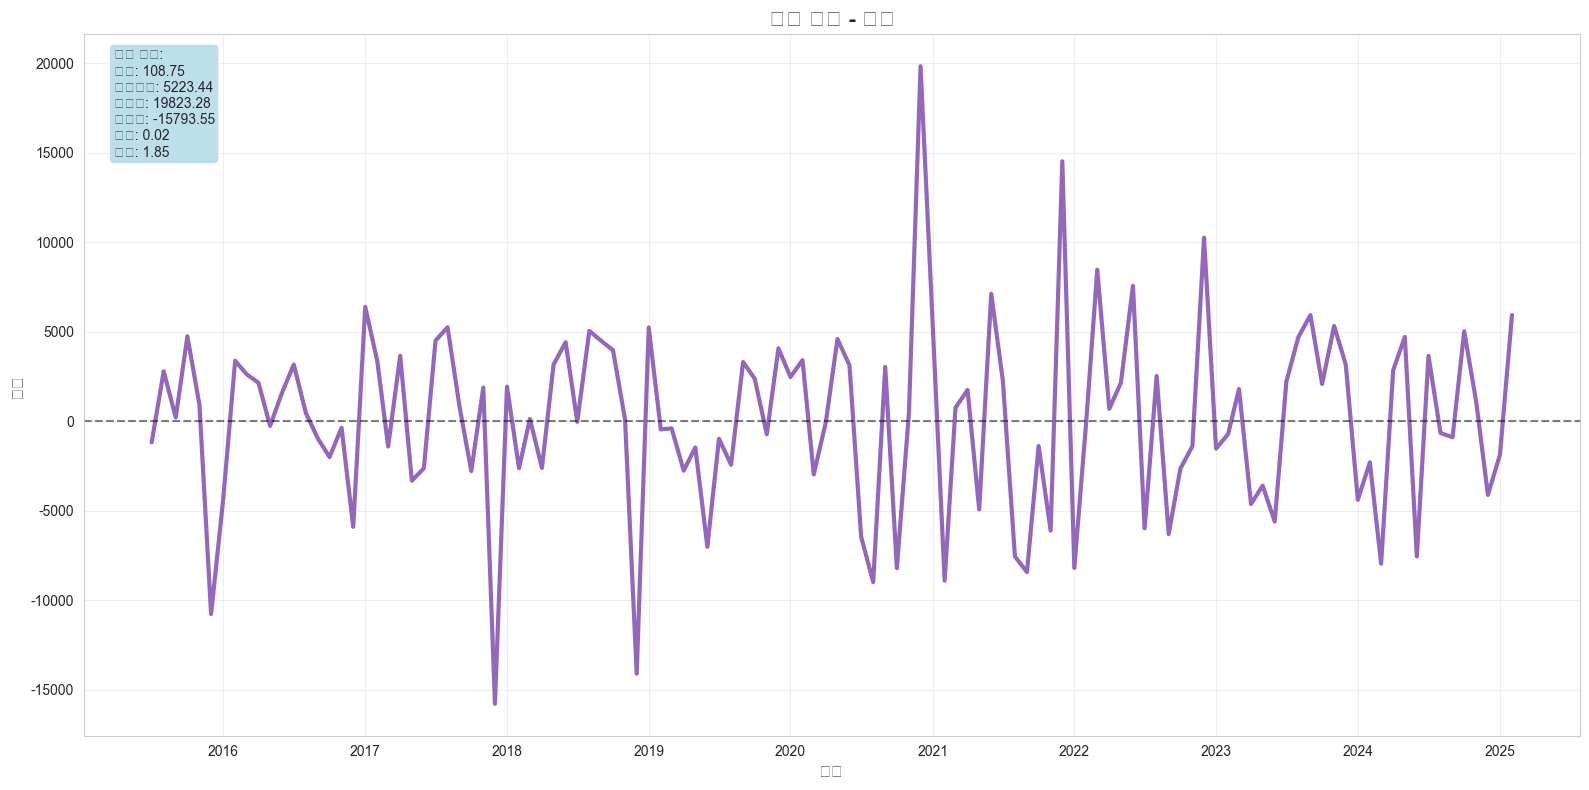

In [39]:
# 5. 잔차 성분
plt.figure(figsize=(16, 8))

# Seaborn용 데이터프레임 생성
plot_data = pd.DataFrame({
    'Date': decomposition.resid.index,
    '잔차': decomposition.resid.values
})

# 선 그래프 생성
sns.lineplot(data=plot_data, x='Date', y='잔차', linewidth=3, color='#9467bd')

plt.title('가법 모델 - 잔차', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('잔차', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 잔차 통계
residual_stats = {
    '평균': decomposition.resid.mean(),
    '표준편차': decomposition.resid.std(),
    '최대값': decomposition.resid.max(),
    '최소값': decomposition.resid.min(),
    '왜도': decomposition.resid.skew(),
    '첨도': decomposition.resid.kurtosis()
}

stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in residual_stats.items()])
plt.text(0.02, 0.98, f'잔차 통계:\n{stats_text}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()


In [40]:
# 14. 시계열 분해 결과 요약
print("=== 시계열 분해 결과 요약 ===")

# 분해 결과 데이터프레임 생성
decomposition_results = pd.DataFrame({
    'period': monthly_data.index,
    'observed': decomposition.observed,
    'trend': decomposition.trend,
    'seasonal': decomposition.seasonal,
    'residual': decomposition.resid
})

print("분해 결과 데이터프레임:")
print(decomposition_results.head())

# 각 성분별 요약 통계
print(f"\n각 성분별 요약 통계:")
print(f"관측값 평균: {decomposition_results['observed'].mean():.2f}")
print(f"추세 평균: {decomposition_results['trend'].mean():.2f}")
print(f"계절성 평균: {decomposition_results['seasonal'].mean():.2f}")
print(f"잔차 평균: {decomposition_results['residual'].mean():.2f}")

print(f"\n분해 완료!")


=== 시계열 분해 결과 요약 ===
분해 결과 데이터프레임:
               period  observed  trend     seasonal  residual
period                                                       
2015-01-01 2015-01-01   21139.0    NaN -6676.638773       NaN
2015-02-01 2015-02-01   20427.0    NaN -7611.905440       NaN
2015-03-01 2015-03-01   25231.0    NaN   801.938079       NaN
2015-04-01 2015-04-01   19828.0    NaN -1391.548032       NaN
2015-05-01 2015-05-01   20469.0    NaN -2745.071181       NaN

각 성분별 요약 통계:
관측값 평균: 44540.09
추세 평균: 45820.69
계절성 평균: -148.46
잔차 평균: 108.75

분해 완료!


=== 분기별 추이 분석 ===
분기별 데이터:
    year  quarter     value
0   2015        1   66797.0
1   2015        2   69357.0
2   2015        3   70039.0
3   2015        4   92478.0
4   2016        1   75494.0
5   2016        2   97670.0
6   2016        3   94495.0
7   2016        4  109955.0
8   2017        1   97076.0
9   2017        2  102975.0
10  2017        3  102572.0
11  2017        4   98626.0
12  2018        1   87449.0
13  2018        2  114803.0
14  2018        3  114347.0
15  2018        4  120021.0
16  2019        1  102656.0
17  2019        2  107390.0
18  2019        3  120466.0
19  2019        4  160936.0
20  2020        1  137580.0
21  2020        2  163894.0
22  2020        3  142488.0
23  2020        4  194189.0
24  2021        1  152963.0
25  2021        2  176779.0
26  2021        3  149447.0
27  2021        4  200095.0
28  2022        1  167292.0
29  2022        2  198008.0
30  2022        3  169403.0
31  2022        4  204762.0
32  2023        1  164687.0
33  2023        2  16

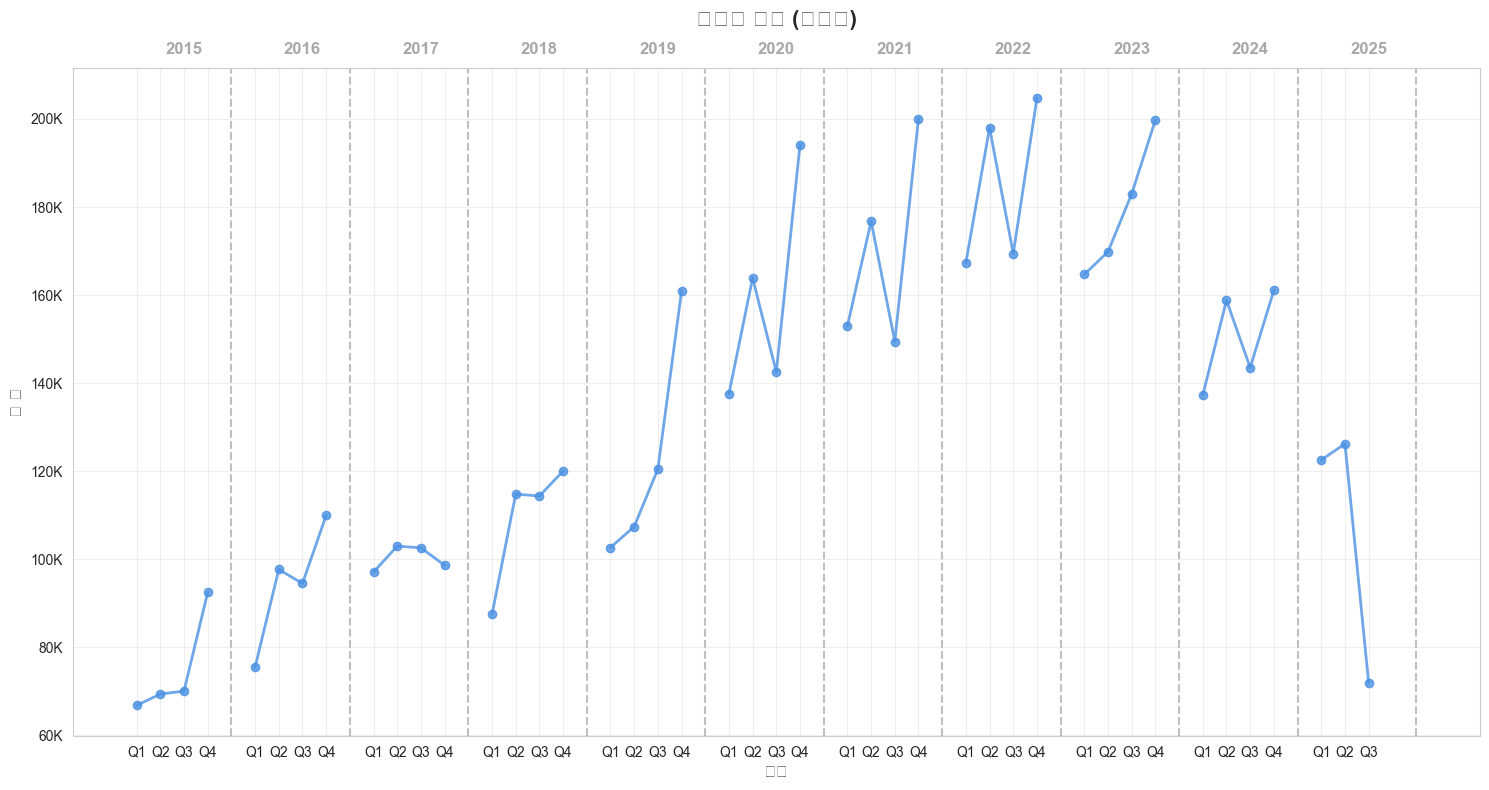


=== 분기별 추이 요약 ===
총 분석 분기 수: 43
날짜 범위: 2015-2025
평균 분기별 값: 132,584
최대 분기별 값: 204,762
최소 분기별 값: 66,797

상위 5개 분기:
2022.0-Q4.0: 204,762
2021.0-Q4.0: 200,095
2023.0-Q4.0: 199,790
2022.0-Q2.0: 198,008
2020.0-Q4.0: 194,189

=== 분기별 패턴 분석 ===
분기별 평균 값:
Q1: 119,253
Q2: 135,070
Q3: 123,787
Q4: 154,194

최고 성과 분기: Q4 (평균: 154,194)
최저 성과 분기: Q1 (평균: 119,253)


In [41]:
# 추가 분석: 분기별 추이 분석
print("=== 분기별 추이 분석 ===")

# period가 datetime인지 확인
df['period'] = pd.to_datetime(df['period'])

# 연도와 분기 추출
df['year'] = df['period'].dt.year
df['quarter'] = df['period'].dt.quarter

# 연도와 분기별로 그룹화하여 값 합계
quarterly_data = df.groupby(['year', 'quarter'])['value'].sum().reset_index()

print("분기별 데이터:")
print(quarterly_data)

# 분기별 추이 시각화
plt.figure(figsize=(15, 8))

# 고유 연도와 분기 가져오기
years = sorted(quarterly_data['year'].unique())
quarters = [1, 2, 3, 4]

# 각 연도-분기 조합에 대한 x축 위치 생성
x_positions = []
x_labels = []
values = []

for i, year in enumerate(years):
    year_data = quarterly_data[quarterly_data['year'] == year]
    
    # 이 연도의 분기들에 대한 위치 계산
    year_start_pos = i * 5  # 각 연도는 5개 위치를 가짐 (4분기 + 1개 간격)
    
    for j, quarter in enumerate(quarters):
        quarter_data = year_data[year_data['quarter'] == quarter]
        if not quarter_data.empty:
            pos = year_start_pos + j
            x_positions.append(pos)
            x_labels.append(f"{year}-Q{quarter}")
            values.append(quarter_data['value'].iloc[0])
    
    # 연도 경계 표시
    plt.axvline(x=year_start_pos + 4, color='gray', linestyle='--', alpha=0.5)

# 각 연도 내에서만 점과 선 플롯
for i, year in enumerate(years):
    year_data = quarterly_data[quarterly_data['year'] == year]
    year_start_pos = i * 5
    
    year_x_positions = []
    year_values = []
    
    for j, quarter in enumerate(quarters):
        quarter_data = year_data[year_data['quarter'] == quarter]
        if not quarter_data.empty:
            pos = year_start_pos + j
            year_x_positions.append(pos)
            year_values.append(quarter_data['value'].iloc[0])
    
    # 점 플롯
    plt.plot(year_x_positions, year_values, 'o', color='#4A90E2', markersize=6, alpha=0.8)
    
    # 연도 내에서만 선 연결 (연도 간에는 연결하지 않음)
    if len(year_x_positions) > 1:
        plt.plot(year_x_positions, year_values, '-', color='#4A90E2', linewidth=2, alpha=0.8)

# x축 라벨 설정 - 분기만 표시
quarter_labels = []
for label in x_labels:
    quarter_labels.append(label.split('-')[1])  # Q1, Q2, Q3, Q4 추출
plt.xticks(x_positions, quarter_labels, rotation=0)

# 연도 라벨 추가
for i, year in enumerate(years):
    year_start_pos = i * 5
    plt.text(year_start_pos + 2, plt.ylim()[1] * 1.02, str(year), 
             ha='center', va='center', fontsize=12, fontweight='bold', color='darkgray')

# 플롯 커스터마이징
plt.title('분기별 추이 (연도별)', fontsize=16, fontweight='bold', pad=30)
plt.xlabel('분기', fontsize=12)
plt.ylabel('총 값', fontsize=12)
plt.grid(True, alpha=0.3)

# y축을 천 단위로 표시하도록 포맷팅
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

plt.tight_layout()
plt.show()

# 분기별 추이 요약
print("\n=== 분기별 추이 요약 ===")
print(f"총 분석 분기 수: {len(quarterly_data)}")
print(f"날짜 범위: {quarterly_data['year'].min()}-{quarterly_data['year'].max()}")
print(f"평균 분기별 값: {quarterly_data['value'].mean():,.0f}")
print(f"최대 분기별 값: {quarterly_data['value'].max():,.0f}")
print(f"최소 분기별 값: {quarterly_data['value'].min():,.0f}")

# 상위 5개 분기 표시
print("\n상위 5개 분기:")
top_quarters = quarterly_data.nlargest(5, 'value')[['year', 'quarter', 'value']]
for _, row in top_quarters.iterrows():
    print(f"{row['year']}-Q{row['quarter']}: {row['value']:,.0f}")

# 분기별 패턴 분석
print(f"\n=== 분기별 패턴 분석 ===")
quarterly_avg = quarterly_data.groupby('quarter')['value'].mean()
print("분기별 평균 값:")
for quarter, avg_value in quarterly_avg.items():
    print(f"Q{quarter}: {avg_value:,.0f}")

# 최고/최저 분기
best_quarter = quarterly_avg.idxmax()
worst_quarter = quarterly_avg.idxmin()
print(f"\n최고 성과 분기: Q{best_quarter} (평균: {quarterly_avg[best_quarter]:,.0f})")
print(f"최저 성과 분기: Q{worst_quarter} (평균: {quarterly_avg[worst_quarter]:,.0f})")


=== 분류1 기준 TOP 5 시각화 ===

분류1 기준 TOP 5 (총 판매량):
분류1
Door Entry    3723430.0
인터폰/인터컴        704900.0
DDL            515693.0
PA             349129.0
시큐리티           174967.0
Name: value, dtype: float64

전체 판매량: 5,629,948

TOP 5 비율:
Door Entry: 3,723,430 (66.14%)
인터폰/인터컴: 704,900 (12.52%)
DDL: 515,693 (9.16%)
PA: 349,129 (6.2%)
시큐리티: 174,967 (3.11%)


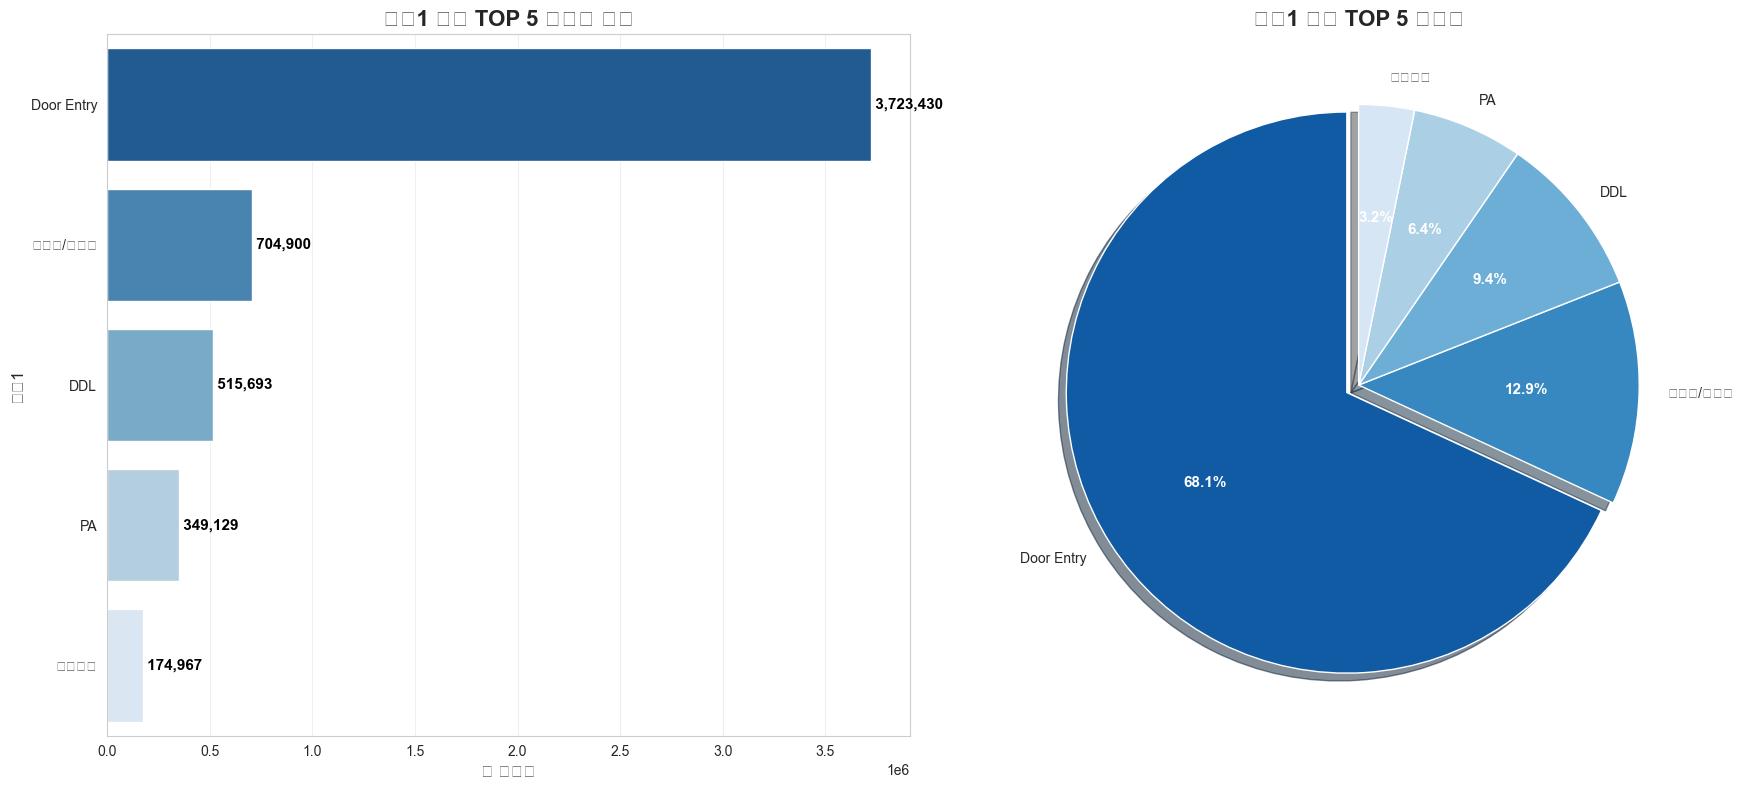


시각화 완료!


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("=== 분류1 기준 TOP 5 시각화 ===")

# 분류1별 총 판매량 계산
category1_sales = df.groupby('분류1')['value'].sum().sort_values(ascending=False)

# TOP 5 추출
top5_categories = category1_sales.head(5)

print("\n분류1 기준 TOP 5 (총 판매량):")
print(top5_categories)

# 비율 계산
total_sales = category1_sales.sum()
top5_percentages = (top5_categories / total_sales * 100).round(2)

print(f"\n전체 판매량: {total_sales:,.0f}")
print("\nTOP 5 비율:")
for category, sales in top5_categories.items():
    pct = top5_percentages[category]
    print(f"{category}: {sales:,.0f} ({pct}%)")

# === 시각화 ===
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# -------------------------------------------------------
# 1. 왼쪽: 막대 그래프 (수평)
# -------------------------------------------------------
top5_df = pd.DataFrame({
    '분류1': top5_categories.index,
    '총판매량': top5_categories.values
})

# palette='Blues_r': 진한 파랑 -> 연한 파랑 순서
sns.barplot(data=top5_df, x='총판매량', y='분류1', palette='Blues_r', ax=axes[0], edgecolor='white')

axes[0].set_title('분류1 기준 TOP 5 판매량 비교', fontsize=16, fontweight='bold')
axes[0].set_xlabel('총 판매량', fontsize=12)
axes[0].set_ylabel('분류1', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='x')

# 막대 옆에 실제 값 텍스트 표시
for i, v in enumerate(top5_categories.values):
    # x좌표(v)보다 약간 오른쪽(+ v*0.01)에 텍스트 표시
    axes[0].text(v, i, f' {v:,.0f}', va='center', ha='left', fontsize=11, fontweight='bold', color='black')


# -------------------------------------------------------
# 2. 오른쪽: 파이 차트
# -------------------------------------------------------
# 파이 차트도 색상 통일감을 위해 Blues_r 사용
colors = sns.color_palette('Blues_r', 5) 

wedges, texts, autotexts = axes[1].pie(top5_categories.values, 
                                        labels=top5_categories.index,
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90,
                                        explode=[0.05, 0, 0, 0, 0], # 1등만 살짝 떼어내기 효과
                                        shadow=True)

axes[1].set_title('분류1 기준 TOP 5 점유율', fontsize=16, fontweight='bold')

# 파이 차트 내부 텍스트 스타일 조정
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

print("\n시각화 완료!")